# Unsupervised Deep Learning Project

**Authors:** Ameya Kulkarni, Felipe Mansilla, Jules Crevola, Giacomo Lustri

---

This notebook is designed to tackle two core unsupervised deep learning challenges as outlined in the project guidelines:

## 1. Anomaly Detection on Corrupted EMNIST
- Explore techniques for unsupervised anomaly detection on a modified EMNIST dataset.
- Identify dataset corruptions and propose methods for reconstruction.
- Propose appropriate metrics to quantify improvements.

## 2. Exploration of Mode Collapse in GANs
- Train GANs on MNIST (without using labels) to investigate mode collapse.
- Experiment with multiple architectures and seeds to deliberately induce mode collapse.
- Propose and implement strategies to mitigate mode collapse, extending results to other datasets


# Part 1
## Anomaly detection on corrupted EMNIST

In this section we explore two ways of identifying corrupted images. We have a modified version of the EMNIST dataset which contains images which have been corrupted in different ways.

In [1]:
# Reset Jupyter namespace
%reset -f  

import os
import gc
import torch

# Allow duplicate library loading (fix for some environments)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Manually trigger garbage collection
gc.collect()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Apple MPS memory
if torch.mps.is_available():
    torch.mps.reset()

print("RAM and GPU cache cleared!")


RAM and GPU cache cleared!


In [2]:
# Imports

import os
import gc
import gzip
import math
import zipfile
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from torch.amp import autocast, GradScaler


In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Manually trigger garbage collection
gc.collect()

# If you're using GPU, clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

if torch.mps.is_available():
    torch.mps.reset()

print("RAM and GPU cache cleared!")

RAM and GPU cache cleared!


#### Loading the corrupted dataset

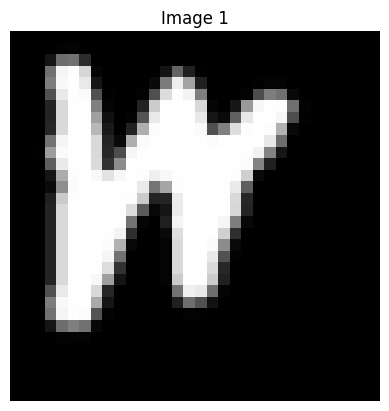

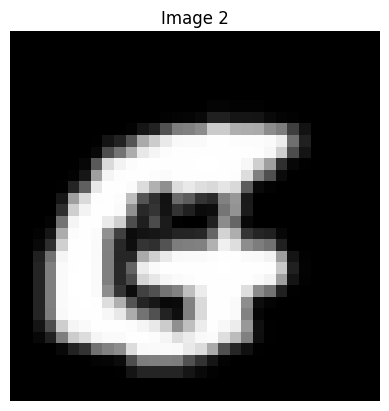

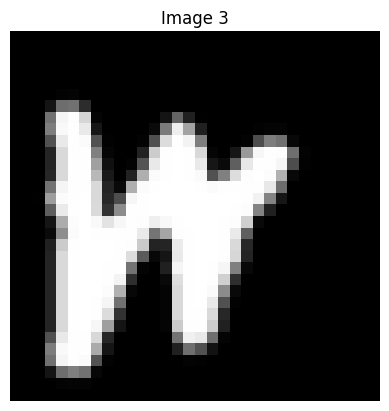

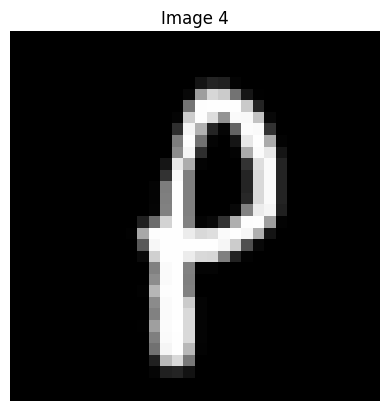

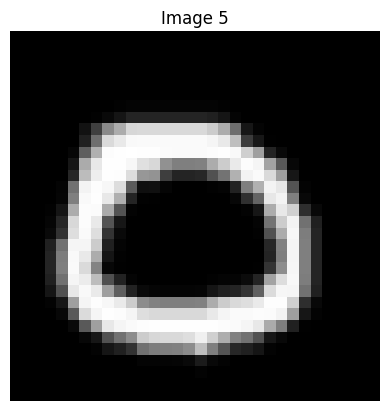

In [4]:
# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, "r") as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)["all_imagesfinal"]  # Load the array
    return data


# Example usage
loaded_images = load_images_from_zip("corrupted_emnist.zip")

# Show the first 5 images
for i in range(5):
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()

## 1. Convolutional Auto-Encoders

#### Approach:
- A convolutional autoencoder is trained on a normal EMNIST dataset (without the labels)
- During inference, anomalies are detected based on reconstruction errors.
- Images which exceed certain thresholds (2 std deviations) from the mean error are flagged as anomalies 

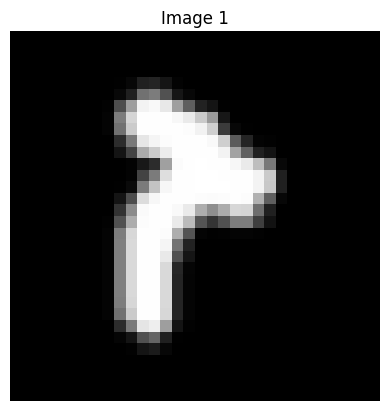

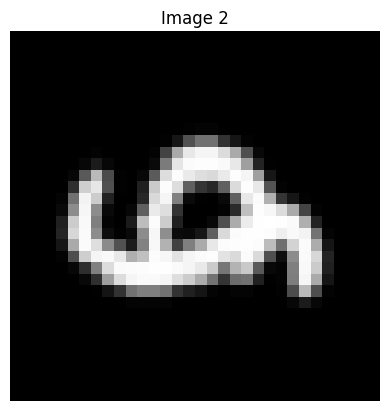

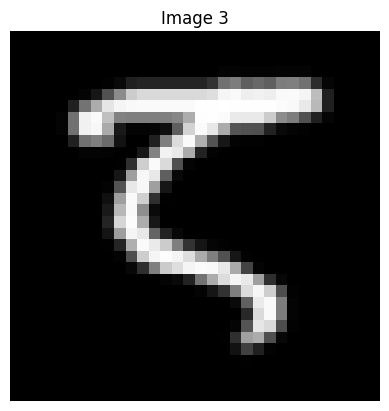

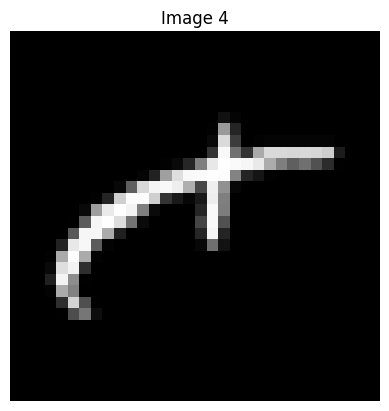

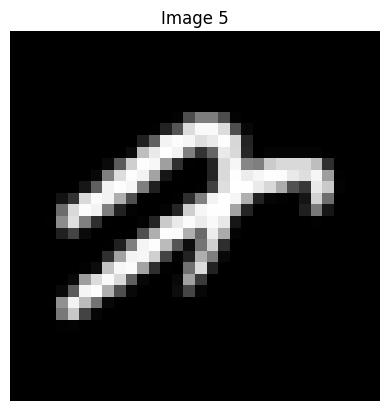

In [5]:
# Generated code

# Function to extract images from the IDX3 file
def extract_images(file_path):
    with gzip.open(file_path, "rb") as f:
        # Skip the header (16 bytes)
        f.read(16)
        # Read the image data
        buffer = f.read()
        # Reshape into 28x28 arrays (native EMNIST format)
        data = np.frombuffer(buffer, dtype=np.uint8).reshape(-1, 28, 28)
    return data


# Path to the correct image file
file_path = "emnist-balanced-train-images-idx3-ubyte.gz"

# Extract EMNIST images
original_emnist_images = extract_images(file_path)


# Resize to 32x32 (Padding)
def resize_to_32x32(images):
    return np.pad(images, ((0, 0), (2, 2), (2, 2)), mode="constant")


# Pad EMNIST images to match 32x32
emnist_images_resized = resize_to_32x32(original_emnist_images)

# Show the first 5 padded images
for i in range(5):
    plt.imshow(emnist_images_resized[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()


In [6]:
# Enable GPU
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [7]:
# Normalize & Convert to tensors
emnist_images_resized = emnist_images_resized / 255.0
emnist_images_tensor = torch.tensor(emnist_images_resized, dtype=torch.float32)
emnist_images_tensor = emnist_images_tensor.unsqueeze(1)


# Create a DataLoader
batch_size = 128
dataset = TensorDataset(emnist_images_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [8]:
# # Adapted Convolutional Autoencoder from the lab  AE_NoisyAE
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [9]:
# Training loop
def train_model(model, loss_fn, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (data,) in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


In [10]:
# Initialize and train the model
model = ConvAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

train_model(model, loss_fn, train_loader, optimizer, epochs=3)


Epoch 1, Loss: 0.11292008141609006
Epoch 2, Loss: 0.007202709364005768
Epoch 3, Loss: 0.0018714304468034854


In [11]:
# Normalize and convert the corrupted images to tensors
corrupted_images = loaded_images / 255.0
corrupted_images_tensor = torch.tensor(corrupted_images, dtype=torch.float32)
corrupted_images_tensor = corrupted_images_tensor.unsqueeze(1)

In [12]:
# Evaluate reconstruction error on corrupted data
model.eval()
with torch.no_grad():
    corrupted_data = corrupted_images_tensor.to(device)
    reconstructed = model(corrupted_data)
    reconstruction_errors = torch.mean(
        (reconstructed - corrupted_data) ** 2, dim=(1, 2, 3)
    )
    print(f"Mean Reconstruction Error: {reconstruction_errors.mean().item()}")


Mean Reconstruction Error: 0.002782597439363599


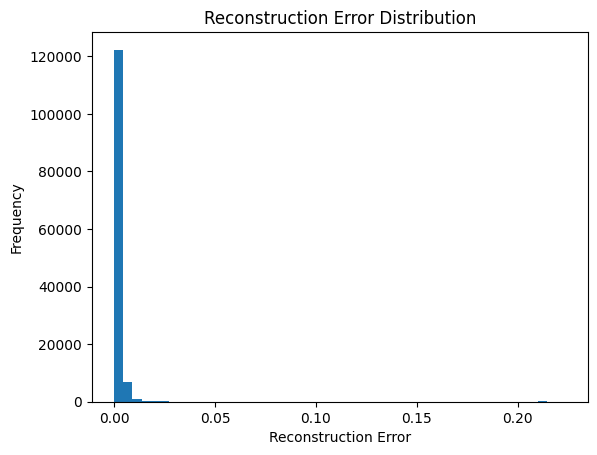

In [13]:
# Plot reconstruction errors distribution

plt.hist(reconstruction_errors.cpu().numpy(), bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()


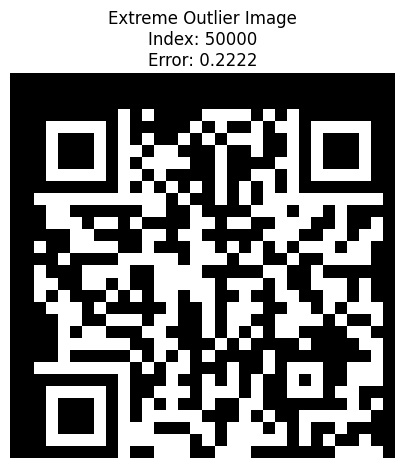

In [14]:
# Found through exploration, hardcoded for repdroducibility
outlier_index = 50000

# Plot the image with the extreme reconstruction error
plt.figure(figsize=(5, 5))
plt.imshow(corrupted_images_tensor[outlier_index, 0].cpu(), cmap="gray")
plt.title(
    f"Extreme Outlier Image\nIndex: {outlier_index}\nError: {reconstruction_errors[outlier_index]:.4f}"
)
plt.axis("off")
plt.show()

This QR code links to an OpenAI site with the DALL-E decoder pickle file hahahaha

https://cdn.openai.com/dall-e/decoder.pkl

In [15]:
# Evaluate reconstruction errors
def detect_anomalies(model, corrupted_data, threshold_factor):
    model.eval()
    with torch.no_grad():
        corrupted_data = corrupted_data.to(device)
        reconstructed = model(corrupted_data)
        # Calculate reconstruction errors
        errors = torch.mean((reconstructed - corrupted_data) ** 2, dim=(1, 2, 3))
        errors = errors.cpu().numpy()
        # Set anomaly threshold
        threshold = errors.mean() + threshold_factor * errors.std()
        anomalies = errors > threshold
        return anomalies, errors, threshold


# Detect anomalies in the corrupted dataset
anomalies, errors, threshold = detect_anomalies(
    model, corrupted_images_tensor, threshold_factor=2
)
print(f"Detected {anomalies.sum()} anomalies out of {len(errors)} images.")


Detected 638 anomalies out of 131057 images.


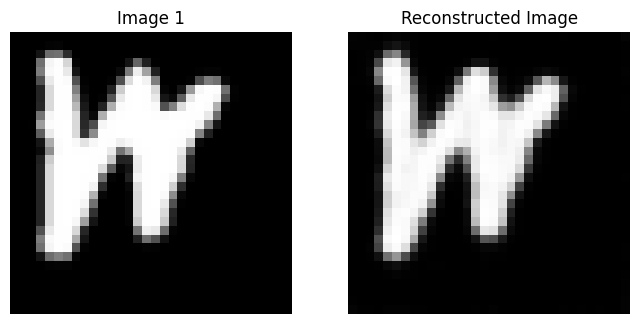

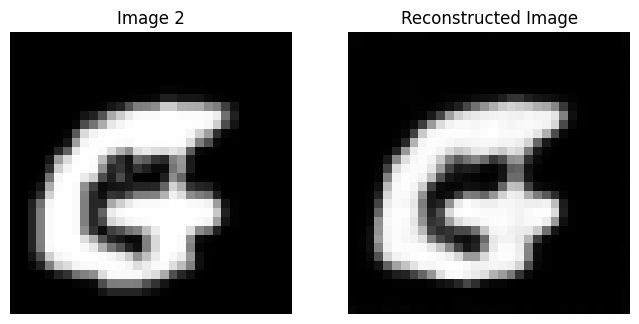

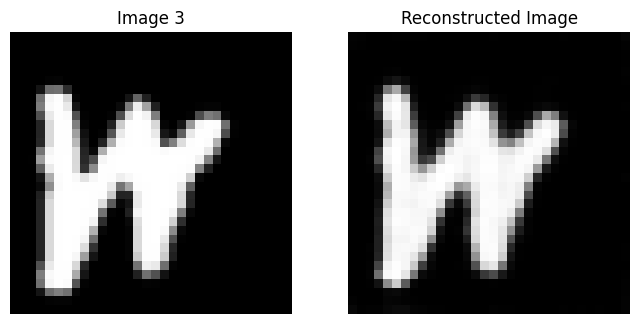

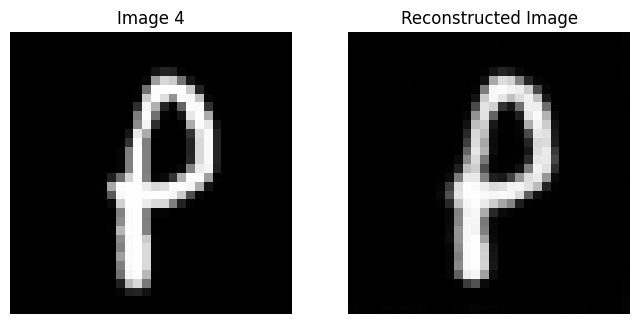

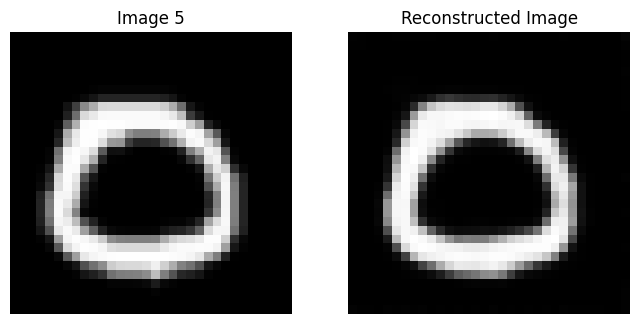

In [16]:
# Visualize the first 5 non-anomalous images
non_anomalous_indices = np.where(~anomalies)[0]
for i in non_anomalous_indices[:5]:
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    # Visualize reconstruction
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[i, 0].cpu().numpy(), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()


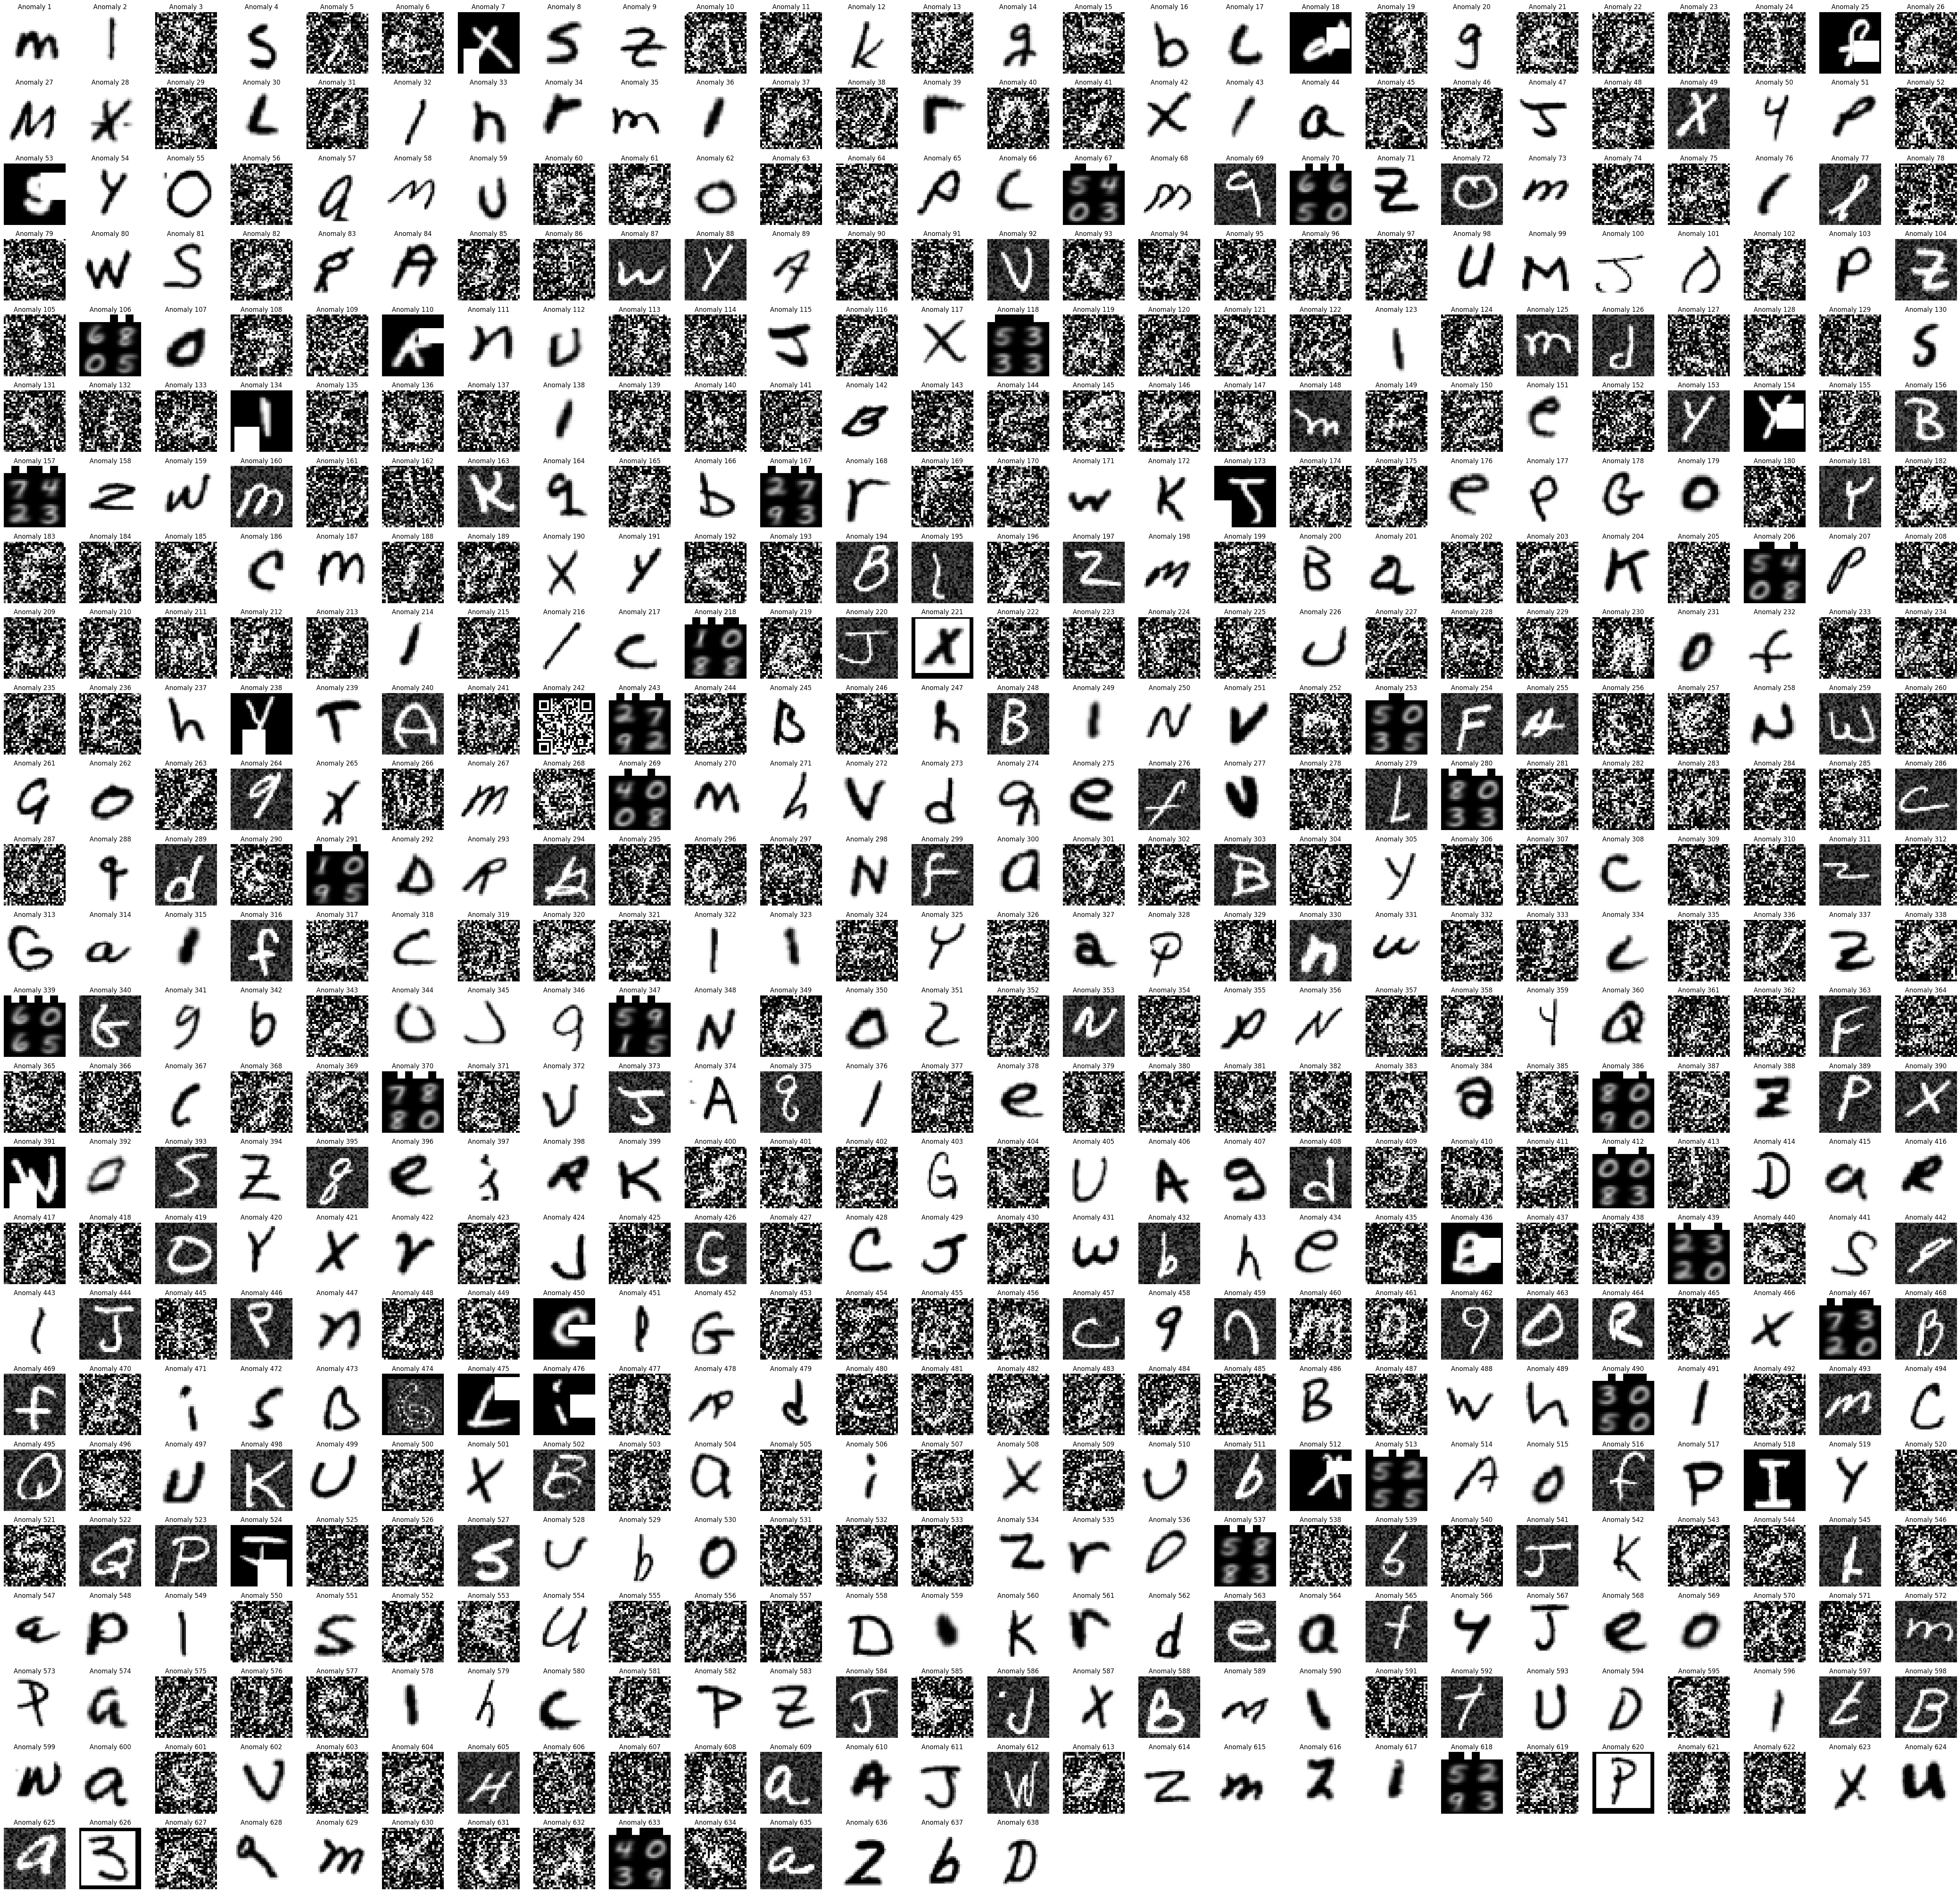

In [17]:
# Code generated with GPT

# visualize all anomalies in a grid


def plot_all_anomalies(original_data, reconstructed_data, anomalies):
    # Get all anomaly indices
    anomaly_indices = np.where(anomalies)[0]
    total_anomalies = len(anomaly_indices)

    # Determine grid size
    grid_size = math.ceil(math.sqrt(total_anomalies))

    # Create the plot
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    for i, idx in enumerate(anomaly_indices):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(original_data[idx, 0].cpu(), cmap="gray")
        plt.title(f"Anomaly {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


plot_all_anomalies(corrupted_images_tensor, reconstructed, anomalies)


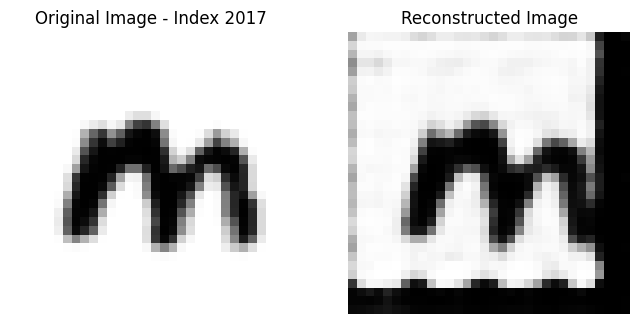

----


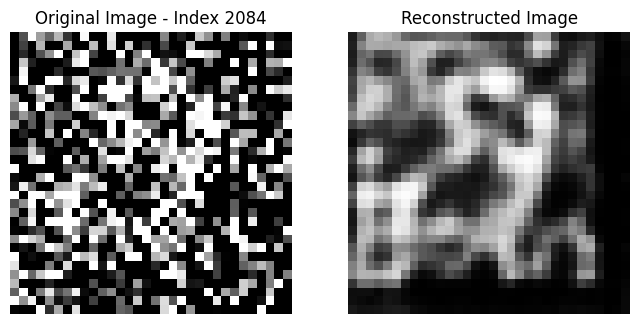

----


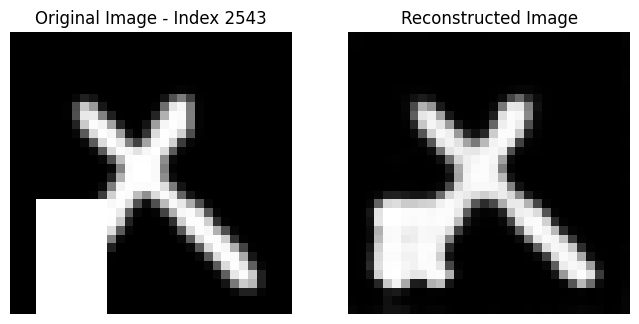

----


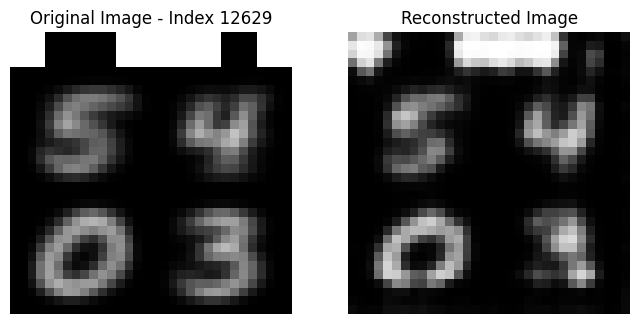

----


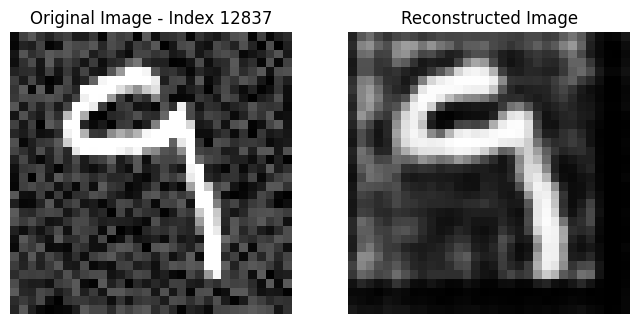

----


In [18]:
# code generated with GPT for visualization

# Hardcoded anomaly indices (past exploration)
specific_indices = [2017, 2084, 2543, 12629, 12837]


# Function to visualize anomalies with hardcoded indices
def plot_hardcoded_anomalies(original_data, reconstructed_data, specific_indices):
    for idx in specific_indices:
        plt.figure(figsize=(8, 4))
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_data[idx, 0].cpu(), cmap="gray")
        plt.title(f"Original Image - Index {idx}")
        plt.axis("off")

        # Reconstructed image
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_data[idx, 0].cpu(), cmap="gray")
        plt.title("Reconstructed Image")
        plt.axis("off")

        plt.show()
        print("----")


# Call the function with hardcoded indices
plot_hardcoded_anomalies(corrupted_images_tensor, reconstructed, specific_indices)


Types of anomalies:
1. Inverted image- Black and white pixel values are inverted
2. Corrupted image- Significant pixel level corruption, leading to the image losing its structure and random patterns
3. Multiple characters- Two or more Characters merged or pictures merged together within the same image
4. Salt-and-Pepper Noise- Dense "salt-and-pepper" noise, where black and white pixels appear randomly distributed throughout the image
5. Image with missing pixles- Certain pixel data is missing leaving white patches or blank areas


## 2. Diffusion Models

#### Approach:
- A diffusion model is trained to predict the noise added to clean images (from MNIST) during a gradual noise diffusion process
- During inference on corrupted EMNIST, the model attempts to predict the noise added to the input image.
- Anomalies are detected using reconstruction errors (difference between noisy input and the model's predicted denoised output).

In [19]:
# Define transformations: convert to tensor and normalize to [-1, 1] range
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the MNIST dataset
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)

# Create a DataLoader for batching
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Check dataset size
print(f"Number of samples in MNIST training dataset: {len(mnist_data)}")


Number of samples in MNIST training dataset: 60000


In [20]:
# Code corrected with the help of GPT (time embedding)


class TimeEmbedding(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -math.log(10000) / (half_dim - 1)
        )
        emb = torch.cat(
            [torch.sin(t[:, None] * emb), torch.cos(t[:, None] * emb)], dim=1
        )
        return self.linear2(F.relu(self.linear1(emb)))


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.time_embed = TimeEmbedding(embed_size=128)

        # Update encoder to handle increased input channels
        self.encoder = nn.Sequential(
            nn.Conv2d(
                1 + 128, 64, 3, padding=1
            ),  # Input channels: 1 (image) + 128 (time embedding)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # Generate time embeddings and concatenate with input
        t_embed = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t_embed], dim=1)

        # Encode and decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [21]:
# add_noise corrected with the help of GPT

# Diffusion parameters
T = 100  # Number of timesteps
betas = torch.linspace(1e-4, 0.02, T)  # Noise schedule
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)


# Sample noisy images
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)  # Proper broadcasting
    noisy_image = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return noisy_image, noise


# Reverse process
def denoise(model, xt, t):
    return model(xt, t)


In [22]:
# Prepare MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)


In [23]:
# Code made faster by implementing mixed precision with the help of GPT

# Move model and data to GPU
model = UNet().to(device)

# Initialize model, loss, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Training loop with mixed precision cause it was slow on MPS
epochs = 7
for epoch in range(epochs):
    for images, _ in mnist_loader:
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)
        t_normalized = t.float() / T
        xt, noise = add_noise(images, t)

        optimizer.zero_grad()
        with autocast(device_type=str(device)):
            pred_noise = model(xt, t_normalized)
            loss = criterion(pred_noise, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/7, Loss: 0.2458
Epoch 2/7, Loss: 0.1526
Epoch 3/7, Loss: 0.1587
Epoch 4/7, Loss: 0.1220
Epoch 5/7, Loss: 0.1259
Epoch 6/7, Loss: 0.1179
Epoch 7/7, Loss: 0.1113


In [24]:
# Prepare corrupted EMNIST dataset
# Code corrected with the help of GPT (channel dimension)

# Normalize and convert corrupted EMNIST to tensors
emnist_images = loaded_images / 255.0  # Scale to [0, 1]
emnist_images = (emnist_images - 0.5) / 0.5  # Normalize to [-1, 1]
emnist_images_tensor = torch.tensor(emnist_images, dtype=torch.float32).unsqueeze(
    1
)  # Add channel dimension

# Create DataLoader for corrupted EMNIST
batch_size = 128
emnist_dataset = torch.utils.data.TensorDataset(emnist_images_tensor)
emnist_loader = torch.utils.data.DataLoader(
    emnist_dataset, batch_size=batch_size, shuffle=False
)


In [25]:
model.eval()

# Anomaly detection on corrupted EMNIST
reconstruction_errors = []
pred_noises = []
original_images = []

with torch.no_grad():
    for (images,) in emnist_loader:
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)  # Random time steps
        t_normalized = t.float() / T  # Normalize time steps

        # Add noise to images
        xt, noise = add_noise(images, t)

        # Predict noise using the trained model
        pred_noise = model(xt, t_normalized)

        # Compute reconstruction error
        errors = torch.mean((xt - pred_noise) ** 2, dim=[1, 2, 3])  # MSE per image
        reconstruction_errors.append(errors.cpu())
        pred_noises.append(pred_noise.cpu())
        original_images.append(images.cpu())

# Combine all batches
reconstruction_errors = torch.cat(reconstruction_errors)
pred_noises = torch.cat(pred_noises)
original_images = torch.cat(original_images)


In [26]:
# Calculate mean and std of reconstruction errors
mean_error = reconstruction_errors.mean().item()
std_error = reconstruction_errors.std().item()
threshold = mean_error + 3 * std_error
anomalies = reconstruction_errors > threshold

# Print anomaly statistics
print(f"Mean Reconstruction Error: {mean_error:.4f}")
print(f"Standard Deviation of Reconstruction Error: {std_error:.4f}")
print(f"Threshold for Anomalies: {threshold:.4f}")
print(f"Number of Anomalies: {torch.sum(anomalies).item()}")


Mean Reconstruction Error: 0.9806
Standard Deviation of Reconstruction Error: 0.4194
Threshold for Anomalies: 2.2387
Number of Anomalies: 17


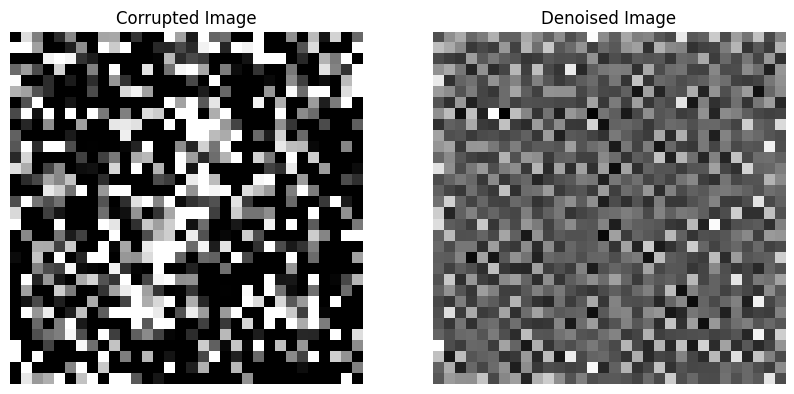

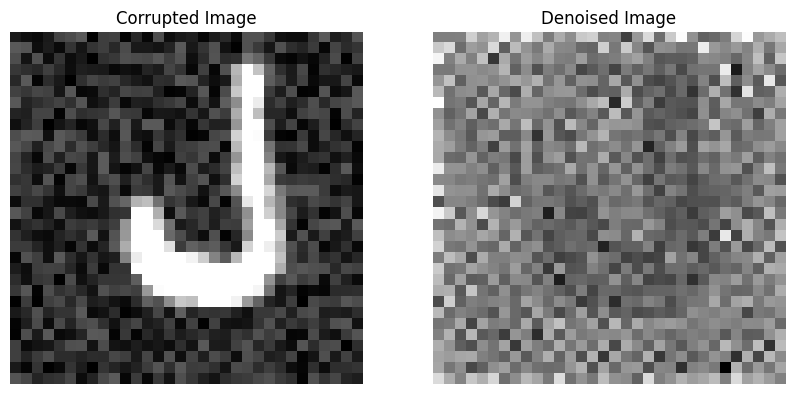

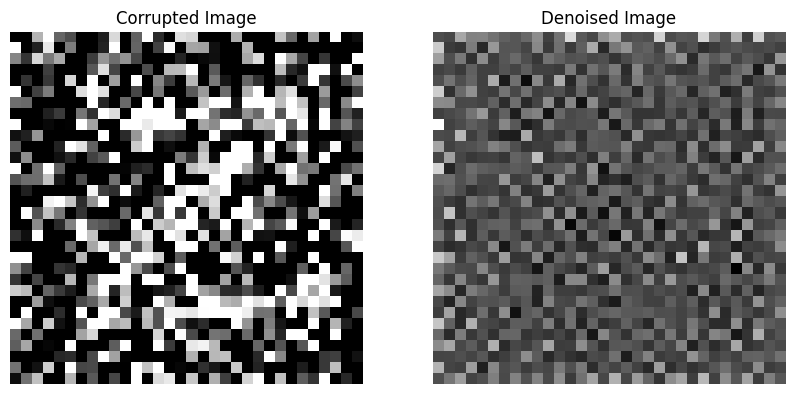

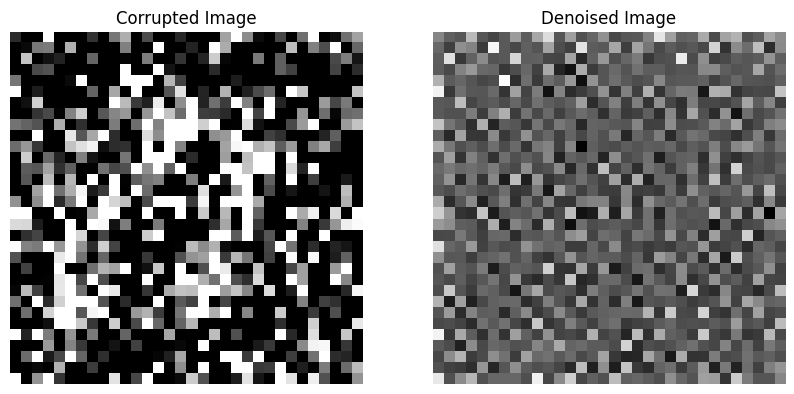

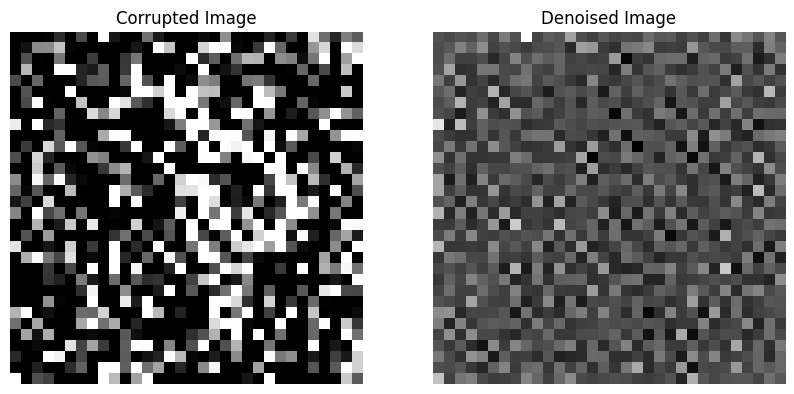

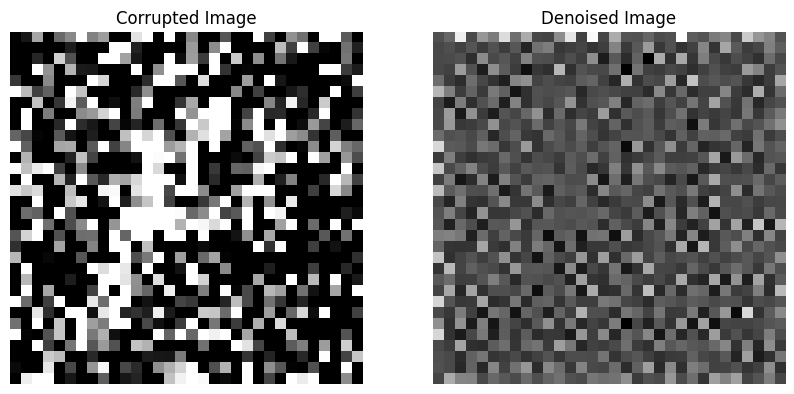

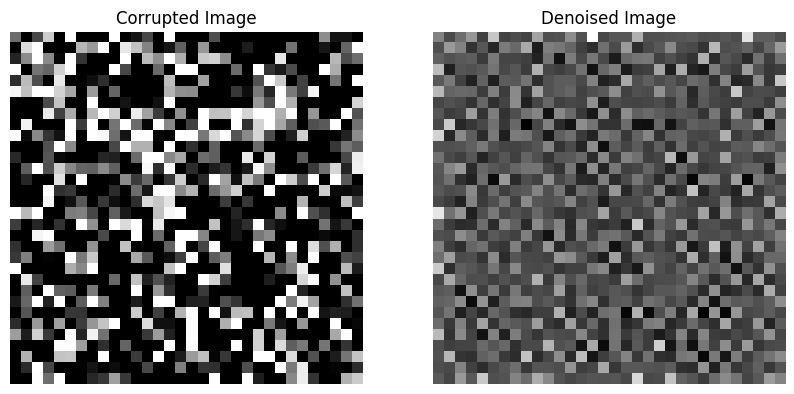

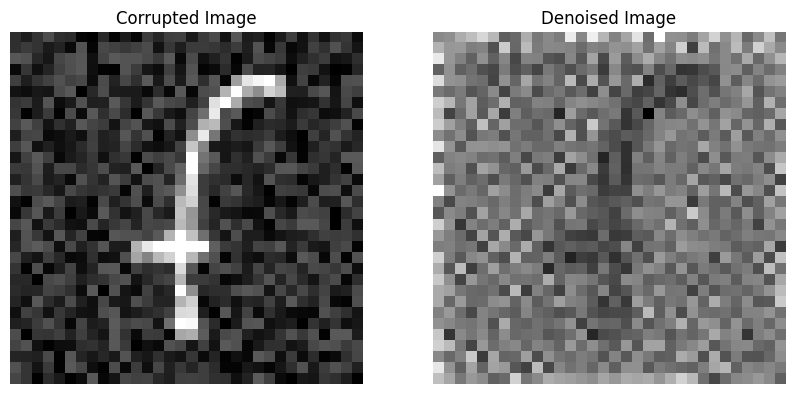

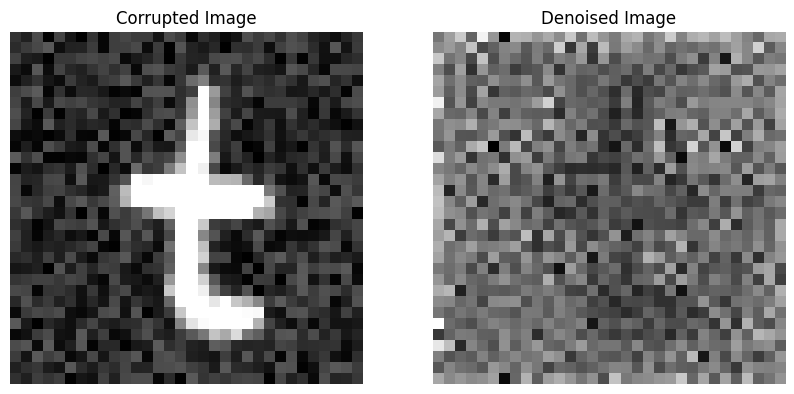

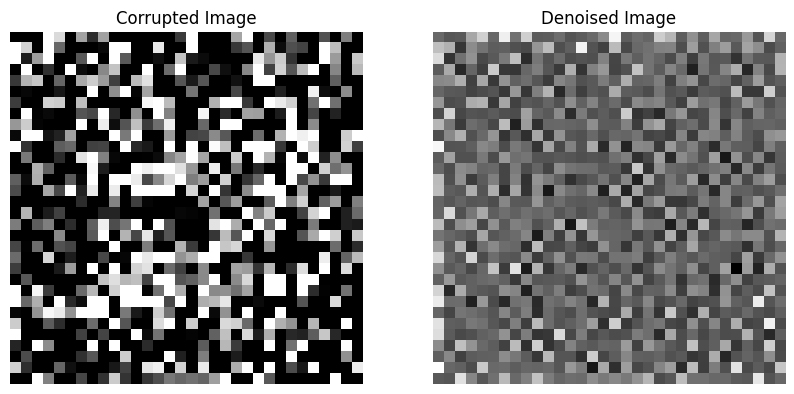

In [27]:
# Code fixed with the help of GPT

# Visualize anomalies
visualized = 0  # Counter for visualized anomalies
max_visualizations = 10  # Maximum anomalies to visualize

for i in range(len(anomalies)):  # Iterate through all images
    if anomalies[i]:  # Check if the image is an anomaly
        corrupted_image = original_images[i].squeeze().numpy()
        denoised_image = pred_noises[i].squeeze().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(corrupted_image, cmap="gray")
        plt.title("Corrupted Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(denoised_image, cmap="gray")
        plt.title("Denoised Image")
        plt.axis("off")

        plt.show()

        visualized += 1
        if visualized >= max_visualizations:
            break  # Stop after visualizing max_visualizations anomalies

if visualized == 0:
    print("No anomalies found for visualization.")


The diffusion model relies on predicting the noise added to an image at different time steps during the forward diffusion process. The random black-and-white pixels in salt-and-pepper noise align well with the random noise the diffusion process generates and learns to model. It finds it difficult to identify the images with dead pixels etc. as anomalies

### Comparison between the two approaches.

#### CAE:
Strengths:
- Simple to implement and train.
- Effective at detecting structural anomalies
Limitations:
- May not capture very subtle anomalies
- Limited by the capacity of the autoencoder to generalize beyond clean images

#### Diffusion Models:
Strengths:
- Diffusion models can model complex distributions and are effective at reconstructing images with added noise.
Weaknesses:
- Computationally intensive to train and infer.
- Requires careful tuning of diffusion parameters and noise schedules


### Methods to Rebuild a Corrupted Dataset

#### 1. **Inverted Images**
   - **Solution:**
     - Apply color inversion using image processing libraries such as OpenCV or PIL in Python.
     - Color inversion flips pixel values to their opposite (e.g., black to white) to restore the original appearance.
     - Verify the image matches the expected dataset style after applying inversion.
   - **Implementation Example:**

      ```python
      from PIL import ImageOps
      inverted_image = ImageOps.invert(image)
      inverted_image.show()
      ```

- Soruce: https://stackoverflow.com/questions/2498875/how-to-invert-colors-of-image-with-pil-python-imaging  

#### 2. **Rubbish or Noisy Data**
   - **Solution:**
     - Identify the type and intensity of noise (Gaussian, salt-and-pepper, etc.).
     - Use noise reduction techniques:
       - **Gaussian Filtering**: Smoothens the image to reduce noise.
       - **Median Filtering**: Particularly effective against salt-and-pepper noise.
     - For heavy noise, use **denoising autoencoders** to reconstruct the clean image by learning the noise pattern.
   - **Implementation Example:**

     ```python
     import cv2
     denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
     cv2.imshow('Denoised', denoised_image)
     
     ```
- Sources: https://stackoverflow.com/questions/62042172/how-to-remove-noise-in-image-opencv-python
https://stackoverflow.com/questions/66395494/how-to-reduce-the-noise-of-an-image-on-python
https://www.omdena.com/blog/denoising-autoencoders
#### 3. **Blurred Images**
   - **Solution:**
     - **Deblurring Techniques**:
       - **Wiener Filtering**: Estimate the original signal by minimizing the mean square error.
       Pros: Computationally efficient and easy to implement
       Cons:Requires precise knowledge of the blur kernel and noise characteristics, these are not always known like for this case.  
       - **Blind Deconvolution**: Estimate both the blur kernel and the deblurred image.
       Pros: Suitable when the blur kernel is unknown, making it flexible for real-world scenarios
       Cons:Computationally expensive and slow, particularly for high-resolution images  
       - **Deep Learning Models**: Use pre-trained models like DeblurGAN for complex cases.
     - Ensure the result preserves critical features of the original image without introducing
     artifacts.
     Pros: Can generalize well to various types of blur when trained on a large and diverse dataset
     Cons: Performance depends on the quality and diversity of the training data and expensive. 
   - **Implementation Example:**
     ```python
     import cv2
     kernel = cv2.getGaussianKernel(ksize=5, sigma=1)
     deblurred_image = cv2.filter2D(image, -1, kernel)
     cv2.imshow('Deblurred', deblurred_image)
     ```
- Sources: Call with AI expert from my company that explianed to me what all of this meant. His name is Mahmoud Bidry, PhD Student in AI.

#### 4. **Pixel Loss**
   - **Solution:**
     - **Interpolation Techniques**:
       - **Bilinear or Bicubic Interpolation**: Estimate missing pixels using neighboring ones.
       Pros: Quick and computationally efficient for small regions of missing pixels
       Cons: Limited effectiveness for large-scale pixel loss. 
     - **Inpainting Methods**:
       - Use neural networks designed for inpainting, such as DeepFill, to predict and fill missing regions.
       - Use OpenCV's `inpaint` function for small missing regions.
     - Validate the reconstructed image against the expected dataset pattern to avoid artifacts.
     Pros: Capable of restoring larger missing regions.
     Cons: May require training on a dataset similar to the corrupted one for optimal results, also very expensive. 
   - **Implementation Example:**
     ```python
     import cv2
     inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
     cv2.imshow('Inpainted', inpainted_image)
     ```
- Source: https://www.youtube.com/watch?v=FAwA6LzFVFw&ab_channel=DSPNITAP
https://www.geeksforgeeks.org/python-opencv-bicubic-interpolation-for-resizing-image/
This amazing code on github: https://github.com/aGIToz/PyInpaint

Disclaimer: we used GPT to help with the synthesis of this markdown.

## Metrics to Quantify Improvements for Dataset Recovery Solutions

---

### **1. Inverted Images**
- **Pixel Accuracy**  
   - **Explanation:** This metric measures the proportion of pixel values that match the original image after correction. A higher percentage indicates successful inversion.  
   - **Limitations:** Sensitive to even small mismatches; it may not align with how humans perceive image quality.

- **Mean Squared Error (MSE)**  
   - **Explanation:** Calculates the average squared differences between the pixel values of the corrected image and the ground truth. A lower value indicates better recovery.  
   - **Limitations:** Penalizes large errors more than small ones and may not align with perceptual differences.

- **Structural Similarity Index (SSIM)**  
   - **Explanation:** Evaluates the similarity between the corrected and original images by comparing structure, luminance, and contrast. A score close to 1 represents high similarity.  
   - **Limitations:** Computationally intensive and less effective for evaluating small pixel-level differences.

---

### **2. Rubbish/Noisy Data**
- **Signal-to-Noise Ratio (SNR)**  
   - **Explanation:** Compares the strength of the image signal to the noise level. A higher ratio suggests better noise reduction.  
   - **Limitations:** Does not consider the human visual impact of noise.

- **Peak Signal-to-Noise Ratio (PSNR)**  
   - **Explanation:** Measures the peak error between the original and the denoised image. Higher values suggest better image quality.  
   - **Limitations:** Fails to reflect perceptual attributes such as edge sharpness or texture retention.

- **SSIM**  
   - **Explanation:** Provides a perceptual assessment of similarity by focusing on structural information. This metric complements PSNR by accounting for human perception.  
   - **Limitations:** May overlook localized noise patterns or fine details.

- **Noise Residuals**  
   - **Explanation:** This metric is the difference between the noisy and denoised images. Smaller residuals indicate effective noise removal.  
   - **Limitations:** Cannot identify whether image details are lost along with the noise.

---

### **3. Blurred Images**
- **Sharpness Metric (Laplacian Variance)**  
   - **Explanation:** Quantifies sharpness by evaluating the variance in the Laplacian operator, which detects edges. Higher values suggest sharper images.  
   - **Limitations:** May not handle various types of blur like motion blur effectively.

- **PSNR and SSIM**  
   - **Explanation:** PSNR provides a numerical measure of similarity, while SSIM gives a perceptual assessment of the recovered image. Together, they offer a balanced evaluation.  
   - **Limitations:** PSNR does not capture perceptual qualities, and SSIM may miss subtle pixel-level blurring.

- **Edge Restoration Quality**  
   - **Explanation:** Assesses how well edges are restored using methods like precision and recall on detected edges. Effective edge restoration indicates successful deblurring.  
   - **Limitations:** Ignores non-edge regions of the image, which may also affect perceived quality.

---

### **4. Pixel Loss Recovery**
- **Reconstruction Accuracy**  
   - **Explanation:** Measures the accuracy of estimated pixel values in the restored regions. Useful for assessing localized pixel recovery.  
   - **Limitations:** Does not account for perceptual integration of restored regions into the entire image.

- **Inpainting Error**  
   - **Explanation:** Calculates the difference between the original and inpainted regions to assess recovery quality. Smaller differences indicate better restoration.  
   - **Limitations:** Focuses only on the repaired regions and ignores the global image quality.

- **PSNR and SSIM**  
   - **Explanation:** Evaluate overall image quality post-restoration. PSNR measures numerical similarity, while SSIM focuses on perceptual coherence.  
   - **Limitations:** PSNR may fail to capture visual coherence, while SSIM might miss minute inconsistencies in restored regions.

- **FID Score (Fréchet Inception Distance)**  
   - **Explanation:** Assesses the realism of generated or inpainted content by comparing feature distributions with a reference dataset. Lower scores indicate higher realism.  
   - **Limitations:** Requires significant computational resources and a pre-trained deep learning model.

Sources:
- https://github.com/3dct/vIQA
- https://unimatrixz.com/blog/latent-space-measuring-image-quality-sharpness-clarity-resolution/
- https://neptune.ai/blog/image-processing-python
- call with AI expert from my company that explianed to me what all of this meant. His name is Mahmoud Bidry, PhD Student in AI.

Chat GPT (also used to edit the MD)


# PART 2

## GAN and mode collapse

We will now explore how GANs can collapse, meaning that the generator manages to fool the discriminator with some elements and thus produces only these ones, thus altering the true distribution of the dataset. We will also see how to mitigate this issue.

## For the MNIST dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using gpu: %s " % torch.cuda.is_available())

Using gpu: False 


In [ ]:
# Define hyperparameters
num_epochs = 20
batch_size = 64
learning_rate = 3e-4
image_size = 28
image_channels = 1
latent_dim = 100

In [ ]:
# Create a custom dataset for MNIST
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ]
)

mnist_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

data_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.82MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# The GAN

### With BCE loss

Epoch [1/20], Batch [100/938], D_real: 0.3818, D_fake: 0.2628, Loss_D: 1.2956, Loss_G: 1.4329
Epoch [1/20], Batch [200/938], D_real: 0.6562, D_fake: 0.2747, Loss_D: 0.9011, Loss_G: 2.6954
Epoch [1/20], Batch [300/938], D_real: 0.3775, D_fake: 0.5034, Loss_D: 1.7640, Loss_G: 0.7695
Epoch [1/20], Batch [400/938], D_real: 0.5684, D_fake: 0.4383, Loss_D: 1.3645, Loss_G: 1.1168
Epoch [1/20], Batch [500/938], D_real: 0.6728, D_fake: 0.3448, Loss_D: 0.8493, Loss_G: 1.1243
Epoch [1/20], Batch [600/938], D_real: 0.6873, D_fake: 0.3603, Loss_D: 0.8502, Loss_G: 1.1559
Epoch [1/20], Batch [700/938], D_real: 0.7759, D_fake: 0.3329, Loss_D: 0.6895, Loss_G: 1.2537
Epoch [1/20], Batch [800/938], D_real: 0.7966, D_fake: 0.2388, Loss_D: 0.5128, Loss_G: 1.6261
Epoch [1/20], Batch [900/938], D_real: 0.7463, D_fake: 0.3244, Loss_D: 0.7090, Loss_G: 1.2455


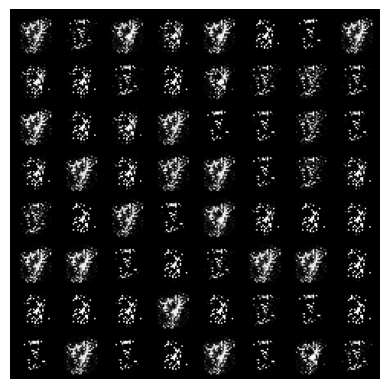

Epoch [2/20], Batch [100/938], D_real: 0.7710, D_fake: 0.3429, Loss_D: 0.7106, Loss_G: 1.2143
Epoch [2/20], Batch [200/938], D_real: 0.8090, D_fake: 0.2255, Loss_D: 0.4896, Loss_G: 1.7405
Epoch [2/20], Batch [300/938], D_real: 0.7122, D_fake: 0.3318, Loss_D: 0.7998, Loss_G: 1.3200
Epoch [2/20], Batch [400/938], D_real: 0.7408, D_fake: 0.3051, Loss_D: 0.7059, Loss_G: 1.3363
Epoch [2/20], Batch [500/938], D_real: 0.7505, D_fake: 0.3103, Loss_D: 0.7138, Loss_G: 1.3641
Epoch [2/20], Batch [600/938], D_real: 0.7558, D_fake: 0.2660, Loss_D: 0.6372, Loss_G: 1.4324
Epoch [2/20], Batch [700/938], D_real: 0.6846, D_fake: 0.2907, Loss_D: 0.8001, Loss_G: 1.5930
Epoch [2/20], Batch [800/938], D_real: 0.7183, D_fake: 0.2763, Loss_D: 0.7579, Loss_G: 1.6522
Epoch [2/20], Batch [900/938], D_real: 0.7605, D_fake: 0.2917, Loss_D: 0.7311, Loss_G: 1.4922


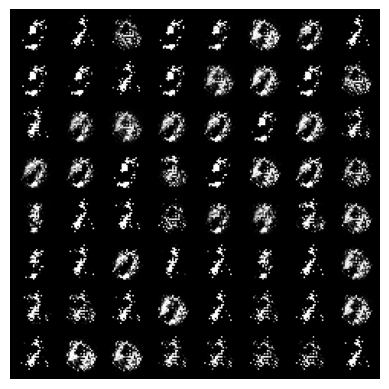

Epoch [3/20], Batch [100/938], D_real: 0.7348, D_fake: 0.3402, Loss_D: 0.8187, Loss_G: 1.4894
Epoch [3/20], Batch [200/938], D_real: 0.7227, D_fake: 0.2919, Loss_D: 0.7397, Loss_G: 1.4041
Epoch [3/20], Batch [300/938], D_real: 0.6375, D_fake: 0.3314, Loss_D: 0.9798, Loss_G: 1.3793
Epoch [3/20], Batch [400/938], D_real: 0.7490, D_fake: 0.2792, Loss_D: 0.6924, Loss_G: 1.4399
Epoch [3/20], Batch [500/938], D_real: 0.6762, D_fake: 0.3446, Loss_D: 0.8930, Loss_G: 1.2761
Epoch [3/20], Batch [600/938], D_real: 0.5993, D_fake: 0.3617, Loss_D: 1.1082, Loss_G: 1.3034
Epoch [3/20], Batch [700/938], D_real: 0.6457, D_fake: 0.3422, Loss_D: 0.9550, Loss_G: 1.3214
Epoch [3/20], Batch [800/938], D_real: 0.6908, D_fake: 0.3181, Loss_D: 0.8267, Loss_G: 1.3608
Epoch [3/20], Batch [900/938], D_real: 0.5814, D_fake: 0.3129, Loss_D: 1.0331, Loss_G: 1.4583


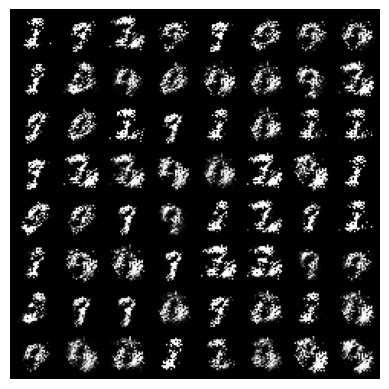

Epoch [4/20], Batch [100/938], D_real: 0.7536, D_fake: 0.3478, Loss_D: 0.7901, Loss_G: 1.3043
Epoch [4/20], Batch [200/938], D_real: 0.7206, D_fake: 0.3327, Loss_D: 0.8574, Loss_G: 1.3591
Epoch [4/20], Batch [300/938], D_real: 0.6860, D_fake: 0.3084, Loss_D: 0.8315, Loss_G: 1.3018
Epoch [4/20], Batch [400/938], D_real: 0.7105, D_fake: 0.2917, Loss_D: 0.7734, Loss_G: 1.3930
Epoch [4/20], Batch [500/938], D_real: 0.7012, D_fake: 0.2991, Loss_D: 0.7769, Loss_G: 1.3800
Epoch [4/20], Batch [600/938], D_real: 0.7212, D_fake: 0.2677, Loss_D: 0.7087, Loss_G: 1.6148
Epoch [4/20], Batch [700/938], D_real: 0.7159, D_fake: 0.3157, Loss_D: 0.8203, Loss_G: 1.3588
Epoch [4/20], Batch [800/938], D_real: 0.7848, D_fake: 0.2876, Loss_D: 0.6681, Loss_G: 1.5656
Epoch [4/20], Batch [900/938], D_real: 0.8144, D_fake: 0.2856, Loss_D: 0.6066, Loss_G: 1.6775


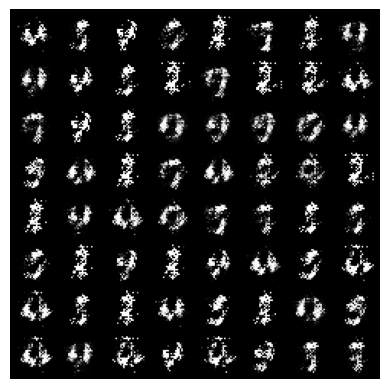

Epoch [5/20], Batch [100/938], D_real: 0.7694, D_fake: 0.2654, Loss_D: 0.6745, Loss_G: 1.6408
Epoch [5/20], Batch [200/938], D_real: 0.7101, D_fake: 0.2718, Loss_D: 0.7522, Loss_G: 1.5129
Epoch [5/20], Batch [300/938], D_real: 0.6957, D_fake: 0.2429, Loss_D: 0.7450, Loss_G: 1.6480
Epoch [5/20], Batch [400/938], D_real: 0.7367, D_fake: 0.2595, Loss_D: 0.6923, Loss_G: 1.4664
Epoch [5/20], Batch [500/938], D_real: 0.7593, D_fake: 0.2402, Loss_D: 0.6501, Loss_G: 1.6841
Epoch [5/20], Batch [600/938], D_real: 0.7782, D_fake: 0.3006, Loss_D: 0.6831, Loss_G: 1.4274
Epoch [5/20], Batch [700/938], D_real: 0.7459, D_fake: 0.2588, Loss_D: 0.6927, Loss_G: 1.7475
Epoch [5/20], Batch [800/938], D_real: 0.7097, D_fake: 0.2789, Loss_D: 0.8615, Loss_G: 1.6921
Epoch [5/20], Batch [900/938], D_real: 0.7377, D_fake: 0.2113, Loss_D: 0.6374, Loss_G: 1.9328


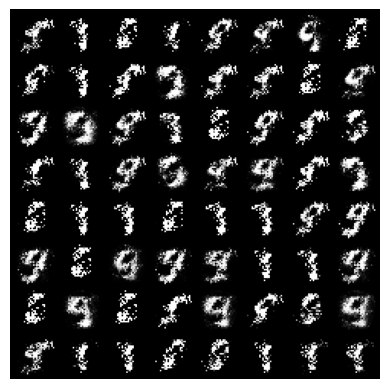

Epoch [6/20], Batch [100/938], D_real: 0.6909, D_fake: 0.2655, Loss_D: 0.8074, Loss_G: 1.6739
Epoch [6/20], Batch [200/938], D_real: 0.7977, D_fake: 0.2173, Loss_D: 0.5488, Loss_G: 1.7829
Epoch [6/20], Batch [300/938], D_real: 0.7850, D_fake: 0.2785, Loss_D: 0.6419, Loss_G: 1.6349
Epoch [6/20], Batch [400/938], D_real: 0.7710, D_fake: 0.2533, Loss_D: 0.6959, Loss_G: 1.8596
Epoch [6/20], Batch [500/938], D_real: 0.7547, D_fake: 0.2618, Loss_D: 0.6728, Loss_G: 1.5942
Epoch [6/20], Batch [600/938], D_real: 0.7604, D_fake: 0.2597, Loss_D: 0.6806, Loss_G: 1.6560
Epoch [6/20], Batch [700/938], D_real: 0.7959, D_fake: 0.2594, Loss_D: 0.6138, Loss_G: 1.6380
Epoch [6/20], Batch [800/938], D_real: 0.8055, D_fake: 0.2042, Loss_D: 0.5293, Loss_G: 1.8938
Epoch [6/20], Batch [900/938], D_real: 0.7118, D_fake: 0.3401, Loss_D: 0.8896, Loss_G: 1.3623


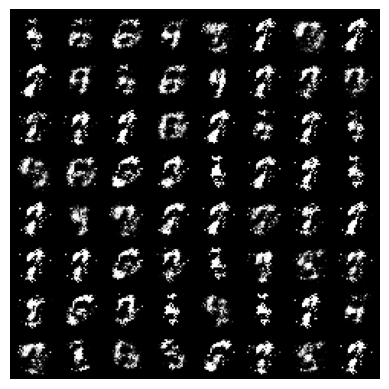

Epoch [7/20], Batch [100/938], D_real: 0.7787, D_fake: 0.3415, Loss_D: 0.7686, Loss_G: 1.4948
Epoch [7/20], Batch [200/938], D_real: 0.7965, D_fake: 0.2711, Loss_D: 0.6320, Loss_G: 1.6521
Epoch [7/20], Batch [300/938], D_real: 0.7262, D_fake: 0.2681, Loss_D: 0.7298, Loss_G: 1.8259
Epoch [7/20], Batch [400/938], D_real: 0.6590, D_fake: 0.2487, Loss_D: 0.9583, Loss_G: 1.6316
Epoch [7/20], Batch [500/938], D_real: 0.6938, D_fake: 0.2138, Loss_D: 0.8021, Loss_G: 1.6747
Epoch [7/20], Batch [600/938], D_real: 0.7575, D_fake: 0.2550, Loss_D: 0.6904, Loss_G: 1.5964
Epoch [7/20], Batch [700/938], D_real: 0.7769, D_fake: 0.2589, Loss_D: 0.7088, Loss_G: 1.6222
Epoch [7/20], Batch [800/938], D_real: 0.6957, D_fake: 0.3204, Loss_D: 0.9589, Loss_G: 1.4725
Epoch [7/20], Batch [900/938], D_real: 0.7712, D_fake: 0.3026, Loss_D: 0.7365, Loss_G: 1.6044


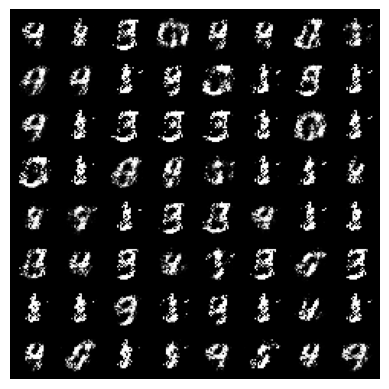

Epoch [8/20], Batch [100/938], D_real: 0.7941, D_fake: 0.1917, Loss_D: 0.5254, Loss_G: 2.1487
Epoch [8/20], Batch [200/938], D_real: 0.7897, D_fake: 0.2097, Loss_D: 0.5591, Loss_G: 1.9377
Epoch [8/20], Batch [300/938], D_real: 0.7944, D_fake: 0.2850, Loss_D: 0.7005, Loss_G: 1.7316
Epoch [8/20], Batch [400/938], D_real: 0.7275, D_fake: 0.2429, Loss_D: 0.7107, Loss_G: 1.6659
Epoch [8/20], Batch [500/938], D_real: 0.8492, D_fake: 0.2329, Loss_D: 0.5254, Loss_G: 1.8687
Epoch [8/20], Batch [600/938], D_real: 0.7133, D_fake: 0.2338, Loss_D: 0.7593, Loss_G: 1.7130
Epoch [8/20], Batch [700/938], D_real: 0.7277, D_fake: 0.2345, Loss_D: 0.7341, Loss_G: 1.8112
Epoch [8/20], Batch [800/938], D_real: 0.7518, D_fake: 0.2245, Loss_D: 0.6414, Loss_G: 1.7419
Epoch [8/20], Batch [900/938], D_real: 0.8275, D_fake: 0.2481, Loss_D: 0.5779, Loss_G: 1.8503


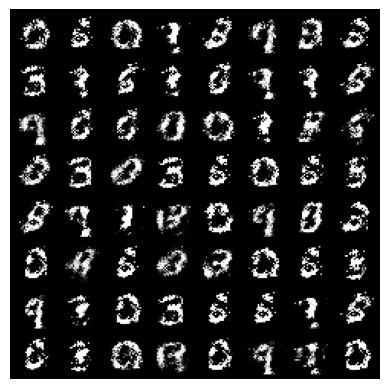

Epoch [9/20], Batch [100/938], D_real: 0.7398, D_fake: 0.2503, Loss_D: 0.7720, Loss_G: 1.6152
Epoch [9/20], Batch [200/938], D_real: 0.7010, D_fake: 0.2433, Loss_D: 0.8204, Loss_G: 1.7107
Epoch [9/20], Batch [300/938], D_real: 0.7040, D_fake: 0.2269, Loss_D: 0.8032, Loss_G: 1.8006
Epoch [9/20], Batch [400/938], D_real: 0.7363, D_fake: 0.2699, Loss_D: 0.7687, Loss_G: 1.8176
Epoch [9/20], Batch [500/938], D_real: 0.7530, D_fake: 0.2845, Loss_D: 0.8472, Loss_G: 1.7303
Epoch [9/20], Batch [600/938], D_real: 0.7657, D_fake: 0.2665, Loss_D: 0.7017, Loss_G: 1.8447
Epoch [9/20], Batch [700/938], D_real: 0.6903, D_fake: 0.2486, Loss_D: 0.8200, Loss_G: 1.7470
Epoch [9/20], Batch [800/938], D_real: 0.7523, D_fake: 0.2149, Loss_D: 0.6385, Loss_G: 1.8733
Epoch [9/20], Batch [900/938], D_real: 0.7455, D_fake: 0.2027, Loss_D: 0.6472, Loss_G: 2.0458


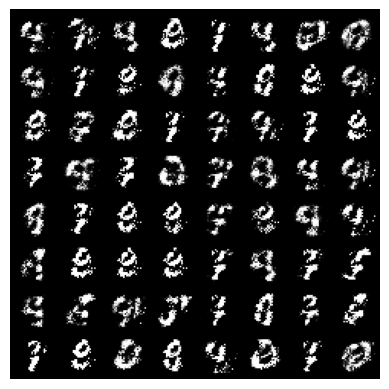

Epoch [10/20], Batch [100/938], D_real: 0.7681, D_fake: 0.2562, Loss_D: 0.7047, Loss_G: 1.7361
Epoch [10/20], Batch [200/938], D_real: 0.7554, D_fake: 0.2494, Loss_D: 0.6878, Loss_G: 1.7382
Epoch [10/20], Batch [300/938], D_real: 0.6995, D_fake: 0.2546, Loss_D: 0.8177, Loss_G: 1.5771
Epoch [10/20], Batch [400/938], D_real: 0.7966, D_fake: 0.2500, Loss_D: 0.6088, Loss_G: 1.8171
Epoch [10/20], Batch [500/938], D_real: 0.7924, D_fake: 0.2232, Loss_D: 0.5802, Loss_G: 1.7280
Epoch [10/20], Batch [600/938], D_real: 0.7758, D_fake: 0.2641, Loss_D: 0.7154, Loss_G: 1.7813
Epoch [10/20], Batch [700/938], D_real: 0.7527, D_fake: 0.2762, Loss_D: 0.7399, Loss_G: 1.8075
Epoch [10/20], Batch [800/938], D_real: 0.8180, D_fake: 0.1963, Loss_D: 0.5012, Loss_G: 2.1125
Epoch [10/20], Batch [900/938], D_real: 0.7053, D_fake: 0.2340, Loss_D: 0.9115, Loss_G: 1.7381


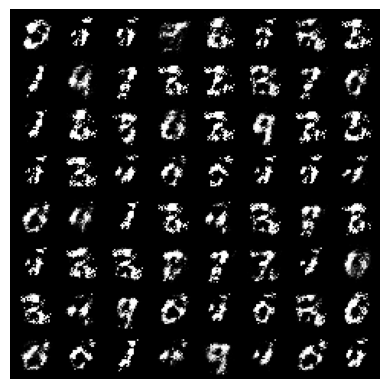

Epoch [11/20], Batch [100/938], D_real: 0.7428, D_fake: 0.2305, Loss_D: 0.6870, Loss_G: 1.8314
Epoch [11/20], Batch [200/938], D_real: 0.7181, D_fake: 0.2648, Loss_D: 0.7938, Loss_G: 1.6715
Epoch [11/20], Batch [300/938], D_real: 0.7571, D_fake: 0.2000, Loss_D: 0.6992, Loss_G: 1.8023
Epoch [11/20], Batch [400/938], D_real: 0.7439, D_fake: 0.2008, Loss_D: 0.6983, Loss_G: 1.8514
Epoch [11/20], Batch [500/938], D_real: 0.7904, D_fake: 0.2494, Loss_D: 0.6861, Loss_G: 1.6887
Epoch [11/20], Batch [600/938], D_real: 0.7455, D_fake: 0.1687, Loss_D: 0.5975, Loss_G: 1.8459
Epoch [11/20], Batch [700/938], D_real: 0.7499, D_fake: 0.2661, Loss_D: 0.7337, Loss_G: 1.8582
Epoch [11/20], Batch [800/938], D_real: 0.8132, D_fake: 0.2204, Loss_D: 0.5891, Loss_G: 1.9671
Epoch [11/20], Batch [900/938], D_real: 0.7328, D_fake: 0.2255, Loss_D: 0.7269, Loss_G: 1.8102


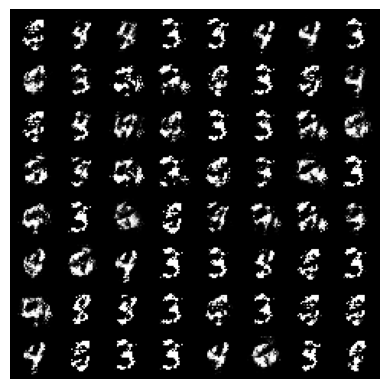

Epoch [12/20], Batch [100/938], D_real: 0.8018, D_fake: 0.1930, Loss_D: 0.5838, Loss_G: 1.9791
Epoch [12/20], Batch [200/938], D_real: 0.7718, D_fake: 0.2631, Loss_D: 0.7855, Loss_G: 1.8135
Epoch [12/20], Batch [300/938], D_real: 0.7938, D_fake: 0.2497, Loss_D: 0.6436, Loss_G: 1.7354
Epoch [12/20], Batch [400/938], D_real: 0.7694, D_fake: 0.2247, Loss_D: 0.7045, Loss_G: 1.9402
Epoch [12/20], Batch [500/938], D_real: 0.8086, D_fake: 0.1919, Loss_D: 0.5286, Loss_G: 1.8764
Epoch [12/20], Batch [600/938], D_real: 0.8519, D_fake: 0.2217, Loss_D: 0.4824, Loss_G: 1.8243
Epoch [12/20], Batch [700/938], D_real: 0.7481, D_fake: 0.2392, Loss_D: 0.7553, Loss_G: 1.9145
Epoch [12/20], Batch [800/938], D_real: 0.7893, D_fake: 0.2498, Loss_D: 0.6748, Loss_G: 2.1017
Epoch [12/20], Batch [900/938], D_real: 0.7164, D_fake: 0.2151, Loss_D: 0.7887, Loss_G: 2.1064


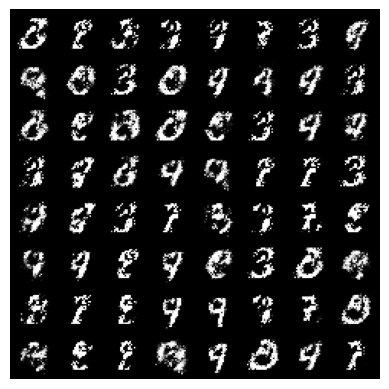

Epoch [13/20], Batch [100/938], D_real: 0.8573, D_fake: 0.2083, Loss_D: 0.4462, Loss_G: 2.0293
Epoch [13/20], Batch [200/938], D_real: 0.7419, D_fake: 0.2380, Loss_D: 0.7185, Loss_G: 2.0038
Epoch [13/20], Batch [300/938], D_real: 0.7331, D_fake: 0.2900, Loss_D: 0.8306, Loss_G: 1.8135
Epoch [13/20], Batch [400/938], D_real: 0.7542, D_fake: 0.2565, Loss_D: 0.7281, Loss_G: 1.7551
Epoch [13/20], Batch [500/938], D_real: 0.7455, D_fake: 0.2165, Loss_D: 0.6444, Loss_G: 1.8563
Epoch [13/20], Batch [600/938], D_real: 0.8111, D_fake: 0.2415, Loss_D: 0.6005, Loss_G: 1.9534
Epoch [13/20], Batch [700/938], D_real: 0.8044, D_fake: 0.2303, Loss_D: 0.6052, Loss_G: 2.0594
Epoch [13/20], Batch [800/938], D_real: 0.7698, D_fake: 0.2659, Loss_D: 0.7603, Loss_G: 1.8001
Epoch [13/20], Batch [900/938], D_real: 0.8264, D_fake: 0.2664, Loss_D: 0.6152, Loss_G: 1.8785


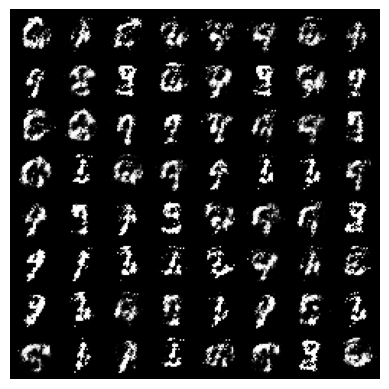

Epoch [14/20], Batch [100/938], D_real: 0.7896, D_fake: 0.2254, Loss_D: 0.6431, Loss_G: 1.9413
Epoch [14/20], Batch [200/938], D_real: 0.8392, D_fake: 0.2593, Loss_D: 0.6098, Loss_G: 1.7318
Epoch [14/20], Batch [300/938], D_real: 0.7412, D_fake: 0.2356, Loss_D: 0.7228, Loss_G: 1.9065
Epoch [14/20], Batch [400/938], D_real: 0.7376, D_fake: 0.2376, Loss_D: 0.7947, Loss_G: 1.8500
Epoch [14/20], Batch [500/938], D_real: 0.7892, D_fake: 0.2411, Loss_D: 0.6853, Loss_G: 1.8443
Epoch [14/20], Batch [600/938], D_real: 0.7339, D_fake: 0.2402, Loss_D: 0.7736, Loss_G: 1.9240
Epoch [14/20], Batch [700/938], D_real: 0.7902, D_fake: 0.2257, Loss_D: 0.6406, Loss_G: 1.8897
Epoch [14/20], Batch [800/938], D_real: 0.8057, D_fake: 0.2052, Loss_D: 0.5703, Loss_G: 2.2392
Epoch [14/20], Batch [900/938], D_real: 0.7913, D_fake: 0.2135, Loss_D: 0.5944, Loss_G: 1.8496


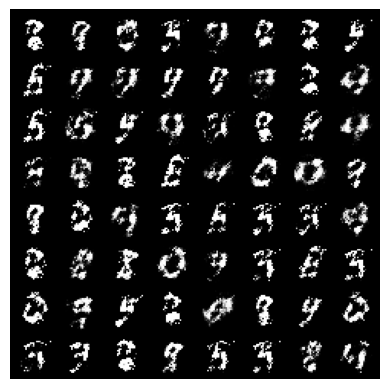

Epoch [15/20], Batch [100/938], D_real: 0.7718, D_fake: 0.1960, Loss_D: 0.5933, Loss_G: 2.0683
Epoch [15/20], Batch [200/938], D_real: 0.8177, D_fake: 0.2108, Loss_D: 0.6216, Loss_G: 2.0605
Epoch [15/20], Batch [300/938], D_real: 0.7789, D_fake: 0.2605, Loss_D: 0.7201, Loss_G: 2.0067
Epoch [15/20], Batch [400/938], D_real: 0.7710, D_fake: 0.1836, Loss_D: 0.6377, Loss_G: 1.8486
Epoch [15/20], Batch [500/938], D_real: 0.7523, D_fake: 0.2432, Loss_D: 0.7674, Loss_G: 1.6969
Epoch [15/20], Batch [600/938], D_real: 0.7991, D_fake: 0.2219, Loss_D: 0.6008, Loss_G: 2.0715
Epoch [15/20], Batch [700/938], D_real: 0.8475, D_fake: 0.2120, Loss_D: 0.5319, Loss_G: 1.8462
Epoch [15/20], Batch [800/938], D_real: 0.7833, D_fake: 0.1881, Loss_D: 0.5801, Loss_G: 2.1292
Epoch [15/20], Batch [900/938], D_real: 0.8073, D_fake: 0.1478, Loss_D: 0.5187, Loss_G: 1.8823


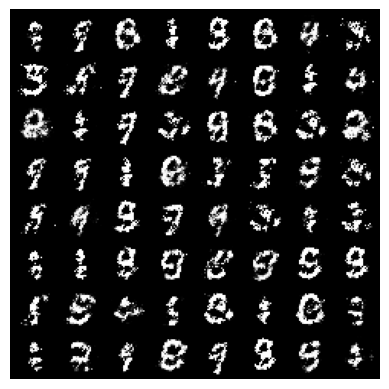

Epoch [16/20], Batch [100/938], D_real: 0.7905, D_fake: 0.2043, Loss_D: 0.5826, Loss_G: 2.1537
Epoch [16/20], Batch [200/938], D_real: 0.7434, D_fake: 0.1787, Loss_D: 0.6288, Loss_G: 2.2034
Epoch [16/20], Batch [300/938], D_real: 0.7619, D_fake: 0.2272, Loss_D: 0.6883, Loss_G: 2.1023
Epoch [16/20], Batch [400/938], D_real: 0.8541, D_fake: 0.1864, Loss_D: 0.4433, Loss_G: 1.8558
Epoch [16/20], Batch [500/938], D_real: 0.8247, D_fake: 0.2244, Loss_D: 0.5409, Loss_G: 1.7162
Epoch [16/20], Batch [600/938], D_real: 0.8529, D_fake: 0.1813, Loss_D: 0.5072, Loss_G: 2.1161
Epoch [16/20], Batch [700/938], D_real: 0.7814, D_fake: 0.2040, Loss_D: 0.5973, Loss_G: 1.8209
Epoch [16/20], Batch [800/938], D_real: 0.8030, D_fake: 0.2281, Loss_D: 0.5897, Loss_G: 1.9628
Epoch [16/20], Batch [900/938], D_real: 0.7899, D_fake: 0.1454, Loss_D: 0.5009, Loss_G: 2.0656


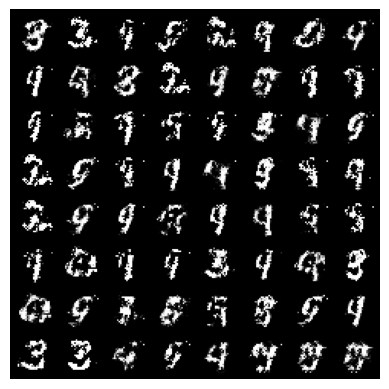

Epoch [17/20], Batch [100/938], D_real: 0.8722, D_fake: 0.2619, Loss_D: 0.5527, Loss_G: 1.9026
Epoch [17/20], Batch [200/938], D_real: 0.7835, D_fake: 0.2272, Loss_D: 0.7314, Loss_G: 2.1632
Epoch [17/20], Batch [300/938], D_real: 0.7842, D_fake: 0.1855, Loss_D: 0.6033, Loss_G: 2.0565
Epoch [17/20], Batch [400/938], D_real: 0.7489, D_fake: 0.2350, Loss_D: 0.8042, Loss_G: 1.9868
Epoch [17/20], Batch [500/938], D_real: 0.7334, D_fake: 0.2149, Loss_D: 0.7259, Loss_G: 2.0121
Epoch [17/20], Batch [600/938], D_real: 0.7942, D_fake: 0.2056, Loss_D: 0.6791, Loss_G: 1.8641
Epoch [17/20], Batch [700/938], D_real: 0.8704, D_fake: 0.2079, Loss_D: 0.4549, Loss_G: 2.2963
Epoch [17/20], Batch [800/938], D_real: 0.7619, D_fake: 0.2353, Loss_D: 0.7961, Loss_G: 1.8749
Epoch [17/20], Batch [900/938], D_real: 0.7324, D_fake: 0.2362, Loss_D: 0.8272, Loss_G: 2.0559


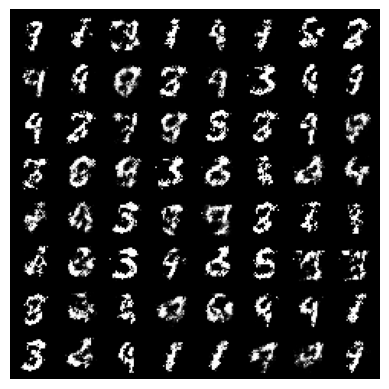

Epoch [18/20], Batch [100/938], D_real: 0.7944, D_fake: 0.2574, Loss_D: 0.6571, Loss_G: 2.0196
Epoch [18/20], Batch [200/938], D_real: 0.7218, D_fake: 0.1734, Loss_D: 0.7124, Loss_G: 2.2321
Epoch [18/20], Batch [300/938], D_real: 0.7203, D_fake: 0.2556, Loss_D: 0.8625, Loss_G: 2.0846
Epoch [18/20], Batch [400/938], D_real: 0.7869, D_fake: 0.2243, Loss_D: 0.6356, Loss_G: 1.9271
Epoch [18/20], Batch [500/938], D_real: 0.7850, D_fake: 0.2048, Loss_D: 0.5939, Loss_G: 2.1011
Epoch [18/20], Batch [600/938], D_real: 0.7531, D_fake: 0.2623, Loss_D: 0.7777, Loss_G: 1.8249
Epoch [18/20], Batch [700/938], D_real: 0.8175, D_fake: 0.2688, Loss_D: 0.6202, Loss_G: 1.8314
Epoch [18/20], Batch [800/938], D_real: 0.7141, D_fake: 0.2789, Loss_D: 0.8396, Loss_G: 1.4703
Epoch [18/20], Batch [900/938], D_real: 0.8558, D_fake: 0.2689, Loss_D: 0.6357, Loss_G: 1.8296


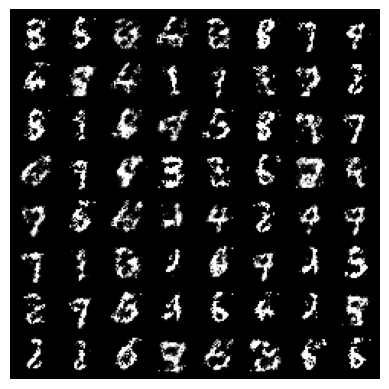

Epoch [19/20], Batch [100/938], D_real: 0.7857, D_fake: 0.2358, Loss_D: 0.6752, Loss_G: 1.7424
Epoch [19/20], Batch [200/938], D_real: 0.7381, D_fake: 0.2227, Loss_D: 0.7422, Loss_G: 1.7967
Epoch [19/20], Batch [300/938], D_real: 0.7666, D_fake: 0.2162, Loss_D: 0.7560, Loss_G: 2.1410
Epoch [19/20], Batch [400/938], D_real: 0.7427, D_fake: 0.2728, Loss_D: 0.7476, Loss_G: 1.7839
Epoch [19/20], Batch [500/938], D_real: 0.8041, D_fake: 0.2202, Loss_D: 0.5820, Loss_G: 1.9024
Epoch [19/20], Batch [600/938], D_real: 0.8135, D_fake: 0.2563, Loss_D: 0.6494, Loss_G: 1.7644
Epoch [19/20], Batch [700/938], D_real: 0.7609, D_fake: 0.2134, Loss_D: 0.6848, Loss_G: 2.1194
Epoch [19/20], Batch [800/938], D_real: 0.7988, D_fake: 0.2244, Loss_D: 0.6162, Loss_G: 2.0698
Epoch [19/20], Batch [900/938], D_real: 0.7772, D_fake: 0.1816, Loss_D: 0.6154, Loss_G: 1.9856


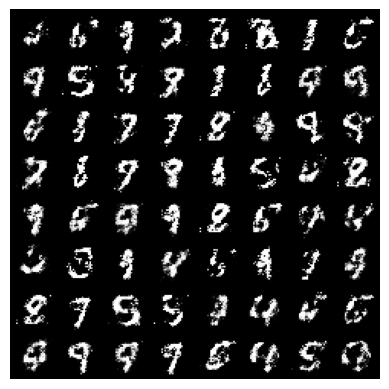

Epoch [20/20], Batch [100/938], D_real: 0.7522, D_fake: 0.2627, Loss_D: 0.7515, Loss_G: 1.8835
Epoch [20/20], Batch [200/938], D_real: 0.7638, D_fake: 0.1944, Loss_D: 0.6812, Loss_G: 1.7623
Epoch [20/20], Batch [300/938], D_real: 0.7857, D_fake: 0.2504, Loss_D: 0.6749, Loss_G: 1.8010
Epoch [20/20], Batch [400/938], D_real: 0.7695, D_fake: 0.2853, Loss_D: 0.7738, Loss_G: 1.7894
Epoch [20/20], Batch [500/938], D_real: 0.7691, D_fake: 0.2385, Loss_D: 0.7172, Loss_G: 1.8884
Epoch [20/20], Batch [600/938], D_real: 0.8139, D_fake: 0.2304, Loss_D: 0.5958, Loss_G: 1.6292
Epoch [20/20], Batch [700/938], D_real: 0.8249, D_fake: 0.2057, Loss_D: 0.5160, Loss_G: 1.8176
Epoch [20/20], Batch [800/938], D_real: 0.7333, D_fake: 0.2772, Loss_D: 0.8192, Loss_G: 1.5026
Epoch [20/20], Batch [900/938], D_real: 0.7835, D_fake: 0.2343, Loss_D: 0.6813, Loss_G: 1.9180


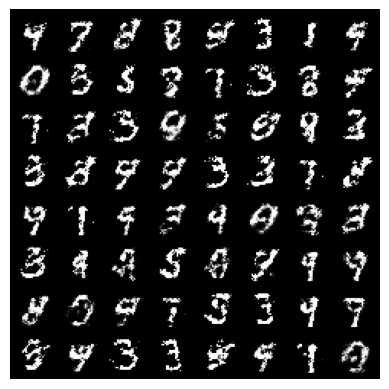

In [ ]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size**2),  # Output: Flattened image
            nn.Sigmoid(),  # Output in the range [0, 1] to match MNIST pixel values
        )

    def forward(self, x):
        return self.model(x)


# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size**2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),  # Output probability
        )

    def forward(self, x):
        return self.model(x)


# Initialize the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate * 0.5)

# Training loop
loss_g_epoch = []
loss_fake_epoch = []
loss_real_epoch = []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        # Move real images to device and flatten
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)  # Flatten to 784

        # Create real and fake labels
        label_real = torch.ones(batch_size, 1).to(device)  # Real labels as 1
        label_fake = torch.zeros(batch_size, 1).to(device)  # Fake labels as 0

        # Train discriminator with real images
        optimizer_d.zero_grad()
        output_real = discriminator(real_images).view(-1, 1)
        loss_real = criterion(output_real, label_real)
        loss_real.backward()

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim).to(device)  # Generate noise
        fake_images = generator(noise)  # Generate fake images
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, label_fake)
        loss_fake.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=5.0)
        optimizer_d.step()

        # Save discriminator losses
        loss_real_epoch.append(loss_real.item())
        loss_fake_epoch.append(loss_fake.item())

        # Train generator
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        output = discriminator(fake_images).view(-1, 1)
        loss_g = criterion(
            output, label_real
        )  # Use real labels to fool the discriminator
        loss_g.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=5.0)
        optimizer_g.step()

        # Save generator loss
        loss_g_epoch.append(loss_g.item())

        # Print progress
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(data_loader)}], "
                f"D_real: {output_real.mean():.4f}, D_fake: {output_fake.mean():.4f}, "
                f"Loss_D: {loss_real.item() + loss_fake.item():.4f}, Loss_G: {loss_g.item():.4f}"
            )

    # Generate and save sample images at the end of each epoch
    with torch.no_grad():
        generator.eval()  # Set generator to evaluation mode
        fake_samples = generator(torch.randn(64, latent_dim).to(device))
        fake_samples = fake_samples.view(
            -1, 1, 28, 28
        )  # Reshape to (batch, channels, height, width)
        fake_grid = torchvision.utils.make_grid(fake_samples, padding=2, normalize=True)
        plt.imshow(
            np.transpose(fake_grid.cpu(), (1, 2, 0))
        )  # Convert to HWC format for plt
        plt.axis("off")
        plt.show()
        generator.train()  # Set generator back to training mode

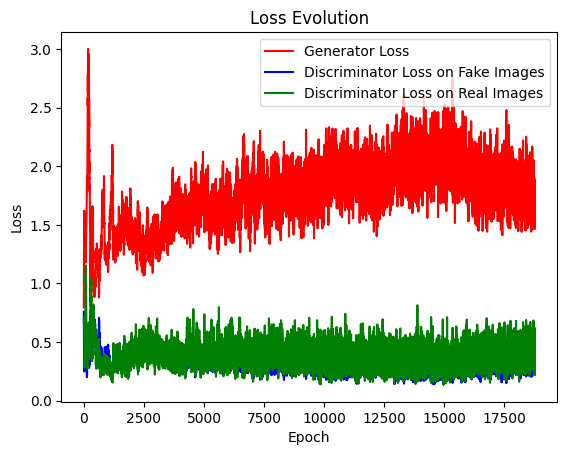

In [ ]:
# Plotting the losses
plt.plot(loss_g_epoch, color="red")
plt.plot(loss_fake_epoch, color="blue")
plt.plot(loss_real_epoch, color="green")
plt.title("Loss Evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(
    [
        "Generator Loss",
        "Discriminator Loss on Fake Images",
        "Discriminator Loss on Real Images",
    ]
)
plt.show()

We note a very big oscillation of the error for the discriminator, both for the real and fake labels, which indicates potential mode collapse.
Moreover, the generated images do not have the same distribution as the initial MNIST dataset. Indeed, 3s and 9s seem to be the most generated numbers at each epoch. We will now fix that with an InfoGAN.

# Info GAN

Here we implement a simplified version of the algorithm presented in the [InfoGAN paper](https://arxiv.org/abs/1606.03657).

The idea is then to provide as in the conditional GAN a random label to the generator but in opposition to the conditional GAN, the discriminator cannot take as input the label (since they are not provided to us) but instead the discriminator will predict a label and this prediction can be trained on fake samples only.

Epoch [1/20] Loss_D: 1.3199, Loss_G: 3.0294
Epoch [2/20] Loss_D: 1.3087, Loss_G: 2.9608
Epoch [3/20] Loss_D: 1.1305, Loss_G: 2.5503
Epoch [4/20] Loss_D: 0.9234, Loss_G: 2.3213
Epoch [5/20] Loss_D: 0.8635, Loss_G: 2.3579
Epoch [6/20] Loss_D: 0.9219, Loss_G: 2.4377
Epoch [7/20] Loss_D: 0.9793, Loss_G: 2.5068
Epoch [8/20] Loss_D: 1.0226, Loss_G: 2.5035
Epoch [9/20] Loss_D: 1.0662, Loss_G: 2.5695
Epoch [10/20] Loss_D: 1.0870, Loss_G: 2.6519


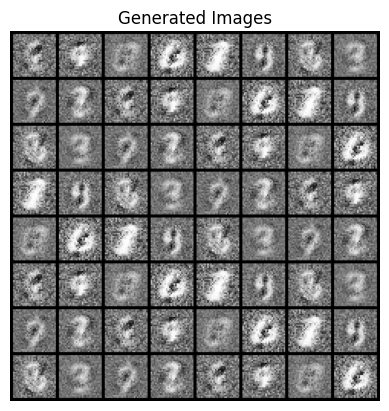

Epoch [11/20] Loss_D: 1.1068, Loss_G: 2.6313
Epoch [12/20] Loss_D: 1.1095, Loss_G: 2.6480
Epoch [13/20] Loss_D: 1.0928, Loss_G: 2.6497
Epoch [14/20] Loss_D: 1.1071, Loss_G: 2.6976
Epoch [15/20] Loss_D: 1.1048, Loss_G: 2.6976
Epoch [16/20] Loss_D: 1.1498, Loss_G: 2.7015
Epoch [17/20] Loss_D: 1.1837, Loss_G: 2.6659
Epoch [18/20] Loss_D: 1.1688, Loss_G: 2.6952
Epoch [19/20] Loss_D: 1.0847, Loss_G: 2.6912
Epoch [20/20] Loss_D: 1.1258, Loss_G: 2.7368


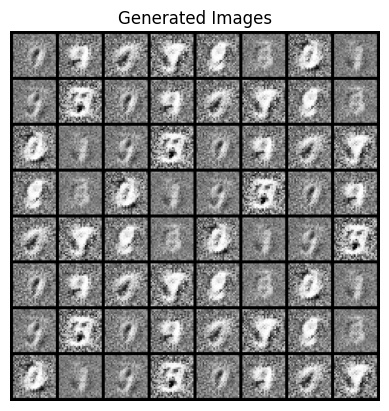

In [ ]:
# Fixed with ChatGPT

import torch.nn.functional as F

# Hyperparameters
z_dim = 62  # Noise vector
c_dim = 10  # Structured latent code (categorical: 10 classes)
hidden_dim = 128
batch_size = 128
lr = 1e-4
nb_epochs = 20
img_dim = 28 * 28


# Generator
class InfoGenerator(nn.Module):
    def __init__(self, z_dim=z_dim, c_dim=c_dim, hidden_dim=hidden_dim):
        super(InfoGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + c_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # Normalize outputs to [-1, 1]
        )

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)
        return self.net(x).view(-1, 1, 28, 28)


# Discriminator with Auxiliary Network (Q)
class InfoDiscriminator(nn.Module):
    def __init__(self, img_dim=img_dim, hidden_dim=hidden_dim, c_dim=c_dim):
        super(InfoDiscriminator, self).__init__()
        self.shared = nn.Sequential(nn.Linear(img_dim, hidden_dim), nn.ReLU())
        self.validity_head = nn.Linear(hidden_dim, 1)
        self.q_head = nn.Linear(hidden_dim, c_dim)  # Predict structured latent code c

    def forward(self, x):
        x = x.view(-1, img_dim)
        shared_out = self.shared(x)
        validity = torch.sigmoid(self.validity_head(shared_out))
        q_pred = self.q_head(shared_out)
        return validity, q_pred


# Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_G = InfoGenerator().to(device)
net_D = InfoDiscriminator().to(device)

# Loss Functions
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy for real/fake discrimination
mutual_info_loss = nn.CrossEntropyLoss()  # Auxiliary loss for structured latent code

# Optimizers
optimizer_G = torch.optim.Adam(net_G.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(net_D.parameters(), lr=lr * 0.5)

# Training loop
loss_D_epoch = []
loss_G_epoch = []

for epoch in range(nb_epochs):
    loss_G = 0
    loss_D = 0

    for real_images, _ in data_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # === Train Discriminator ===
        optimizer_D.zero_grad()

        # Real images
        real_validity, _ = net_D(real_images)
        real_loss = adversarial_loss(
            real_validity, torch.ones(batch_size, 1).to(device)
        )

        # Fake images
        z = torch.randn(batch_size, z_dim).to(device)
        c = (
            F.one_hot(torch.randint(0, c_dim, (batch_size,)), num_classes=c_dim)
            .type(torch.FloatTensor)
            .to(device)
        )
        fake_images = net_G(z, c)
        fake_validity, _ = net_D(fake_images.detach())
        fake_loss = adversarial_loss(
            fake_validity, torch.zeros(batch_size, 1).to(device)
        )

        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        loss_D += d_loss.item()

        # === Train Generator ===
        optimizer_G.zero_grad()

        # Generate fake images and predict validity + latent code
        fake_validity, q_pred = net_D(fake_images)
        g_loss = adversarial_loss(
            fake_validity, torch.ones(batch_size, 1).to(device)
        )  # Fool discriminator
        mi_loss = mutual_info_loss(
            q_pred, torch.argmax(c, dim=1)
        )  # Maximize mutual info
        total_g_loss = g_loss + mi_loss  # Combine adversarial and mutual info losses
        total_g_loss.backward()
        optimizer_G.step()
        loss_G += total_g_loss.item()

    # Track losses for each epoch
    loss_D_epoch.append(loss_D / len(data_loader))
    loss_G_epoch.append(loss_G / len(data_loader))

    print(
        f"Epoch [{epoch + 1}/{nb_epochs}] Loss_D: {loss_D_epoch[-1]:.4f}, Loss_G: {loss_G_epoch[-1]:.4f}"
    )

    # Generate and display images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            c = (
                F.one_hot(
                    torch.arange(0, c_dim).repeat((64 + c_dim - 1) // c_dim)[:64],
                    num_classes=c_dim,
                )
                .type(torch.FloatTensor)
                .to(device)
            )
            generated_images = net_G(z, c)
            grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.title("Generated Images")
            plt.axis("off")
            plt.show()

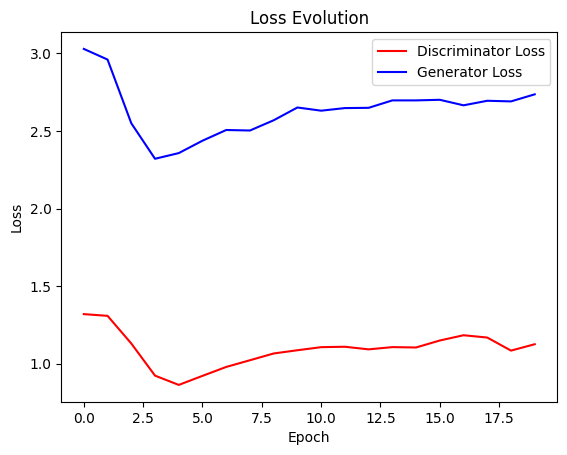

In [ ]:
# plotting the losses
plt.plot(loss_D_epoch, color="red")
plt.plot(loss_G_epoch, color="blue")
plt.title("Loss Evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Discriminator Loss", "Generator Loss"])
plt.show()

We see that the losses do not osciallate as before, even though they reach their minimum pretty early. there would be some improvements to make in the model's architecture but at least we partially solved mode collapse, as even the images (poorly) generated show a better distribution of the digits.

## For the CIFAR dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn.utils.spectral_norm as spectral_norm

In [ ]:
# Define hyperparameters
batch_size = 64
image_size = 32
latent_dim = 100
lr = 0.0002
beta1 = 0.5
epochs = 20

In [ ]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Enable GPU if available
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [ ]:
# Hyperparameters
batch_size = 32  # Massively reduced
lr = 0.0002
lr_generator = 0.01  # Higher
latent_dim = 4  # Reduce latent space to induce mode collapse
n_epochs = 5
lambda_gp = 10
d_updates = 5  # Number of discriminator updates per generator update

Ways to induce mode collapse:
- A small latent space limits the generator's ability to produce diverse outputs.
- Overfit the discriminator by training it much more frequently (D steps > G steps). The generator will exploit weak patterns in the discriminator and produce repetitive outputs.
- Reduced batch size to reduce diversity of images in training data sent at a time
- Higher learning rate for the generator

https://pub.towardsai.net/gan-mode-collapse-explanation-fa5f9124ee73

In [ ]:
# CIFAR-10 Dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root="./data", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)


Files already downloaded and verified


In [ ]:
# Code corrected with the help of GPT (for correct dimensions)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 128, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, img):
        return self.model(img).view(-1)


# Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(
        True
    )
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=device)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_generator, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Fixed noise for testing mode collapse
fixed_noise = torch.zeros(batch_size, latent_dim, device=device)

[Epoch 0/5] [Batch 0/1563] [D loss: 13847.6445] [G loss: -0.3413]
[Epoch 0/5] [Batch 100/1563] [D loss: 0.0258] [G loss: -0.3711]
[Epoch 0/5] [Batch 200/1563] [D loss: 0.0274] [G loss: -0.3879]
[Epoch 0/5] [Batch 300/1563] [D loss: 0.0108] [G loss: -0.3907]
[Epoch 0/5] [Batch 400/1563] [D loss: 0.0019] [G loss: -0.3907]
[Epoch 0/5] [Batch 500/1563] [D loss: 0.0013] [G loss: -0.3904]
[Epoch 0/5] [Batch 600/1563] [D loss: 0.0049] [G loss: -0.3903]
[Epoch 0/5] [Batch 700/1563] [D loss: 0.0014] [G loss: -0.3900]
[Epoch 0/5] [Batch 800/1563] [D loss: 0.0050] [G loss: -0.3900]
[Epoch 0/5] [Batch 900/1563] [D loss: 0.0011] [G loss: -0.3899]
[Epoch 0/5] [Batch 1000/1563] [D loss: 0.0009] [G loss: -0.3899]
[Epoch 0/5] [Batch 1100/1563] [D loss: 0.0014] [G loss: -0.3898]
[Epoch 0/5] [Batch 1200/1563] [D loss: 0.0012] [G loss: -0.3898]
[Epoch 0/5] [Batch 1300/1563] [D loss: 0.0027] [G loss: -0.3897]
[Epoch 0/5] [Batch 1400/1563] [D loss: 0.0007] [G loss: -0.3896]
[Epoch 0/5] [Batch 1500/1563] [D 

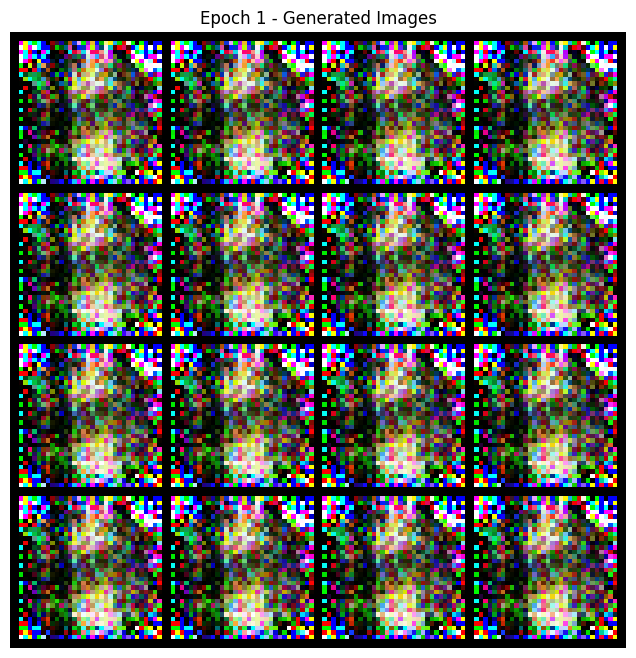

[Epoch 1/5] [Batch 0/1563] [D loss: 0.0022] [G loss: -0.3892]
[Epoch 1/5] [Batch 100/1563] [D loss: 0.0041] [G loss: -0.3892]
[Epoch 1/5] [Batch 200/1563] [D loss: 0.0007] [G loss: -0.3890]
[Epoch 1/5] [Batch 300/1563] [D loss: 0.0036] [G loss: -0.3889]
[Epoch 1/5] [Batch 400/1563] [D loss: 0.0014] [G loss: -0.3888]
[Epoch 1/5] [Batch 500/1563] [D loss: 0.0007] [G loss: -0.3887]
[Epoch 1/5] [Batch 600/1563] [D loss: 0.0012] [G loss: -0.3889]
[Epoch 1/5] [Batch 700/1563] [D loss: 0.0006] [G loss: -0.3888]
[Epoch 1/5] [Batch 800/1563] [D loss: 0.0012] [G loss: -0.3889]
[Epoch 1/5] [Batch 900/1563] [D loss: 0.0011] [G loss: -0.3887]
[Epoch 1/5] [Batch 1000/1563] [D loss: 0.0005] [G loss: -0.3887]
[Epoch 1/5] [Batch 1100/1563] [D loss: 0.0009] [G loss: -0.3887]
[Epoch 1/5] [Batch 1200/1563] [D loss: 0.0004] [G loss: -0.3888]
[Epoch 1/5] [Batch 1300/1563] [D loss: 0.0009] [G loss: -0.3889]
[Epoch 1/5] [Batch 1400/1563] [D loss: 0.0005] [G loss: -0.3891]
[Epoch 1/5] [Batch 1500/1563] [D loss

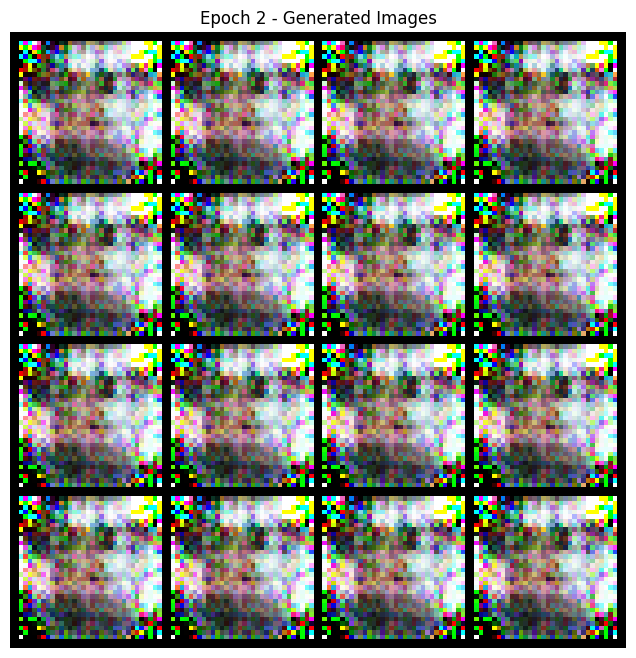

[Epoch 2/5] [Batch 0/1563] [D loss: 0.0005] [G loss: -0.3892]
[Epoch 2/5] [Batch 100/1563] [D loss: 0.0006] [G loss: -0.3892]
[Epoch 2/5] [Batch 200/1563] [D loss: 0.0004] [G loss: -0.3893]
[Epoch 2/5] [Batch 300/1563] [D loss: 0.0002] [G loss: -0.3894]
[Epoch 2/5] [Batch 400/1563] [D loss: 0.0003] [G loss: -0.3898]
[Epoch 2/5] [Batch 500/1563] [D loss: 0.0003] [G loss: -0.3898]
[Epoch 2/5] [Batch 600/1563] [D loss: 0.0003] [G loss: -0.3900]
[Epoch 2/5] [Batch 700/1563] [D loss: 0.0002] [G loss: -0.3899]
[Epoch 2/5] [Batch 800/1563] [D loss: 0.0005] [G loss: -0.3900]
[Epoch 2/5] [Batch 900/1563] [D loss: 0.0003] [G loss: -0.3900]
[Epoch 2/5] [Batch 1000/1563] [D loss: 0.0002] [G loss: -0.3899]
[Epoch 2/5] [Batch 1100/1563] [D loss: 0.0003] [G loss: -0.3903]
[Epoch 2/5] [Batch 1200/1563] [D loss: 0.0003] [G loss: -0.3904]
[Epoch 2/5] [Batch 1300/1563] [D loss: 0.0001] [G loss: -0.3903]
[Epoch 2/5] [Batch 1400/1563] [D loss: 0.0002] [G loss: -0.3903]
[Epoch 2/5] [Batch 1500/1563] [D loss

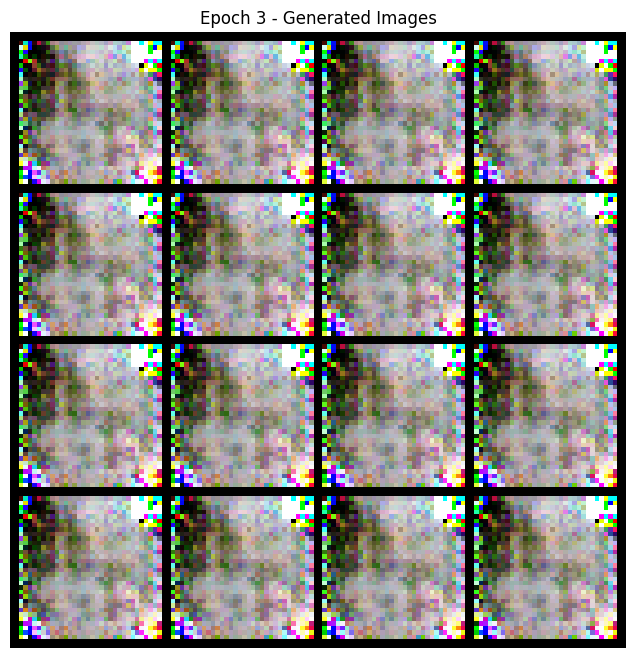

[Epoch 3/5] [Batch 0/1563] [D loss: 0.0003] [G loss: -0.3904]
[Epoch 3/5] [Batch 100/1563] [D loss: 0.0002] [G loss: -0.3903]
[Epoch 3/5] [Batch 200/1563] [D loss: 0.0001] [G loss: -0.3903]
[Epoch 3/5] [Batch 300/1563] [D loss: 0.0023] [G loss: -0.3905]
[Epoch 3/5] [Batch 400/1563] [D loss: 0.0005] [G loss: -0.3906]
[Epoch 3/5] [Batch 500/1563] [D loss: 0.0002] [G loss: -0.3906]
[Epoch 3/5] [Batch 600/1563] [D loss: 0.0003] [G loss: -0.3905]
[Epoch 3/5] [Batch 700/1563] [D loss: 0.0005] [G loss: -0.3905]
[Epoch 3/5] [Batch 800/1563] [D loss: 0.0001] [G loss: -0.3907]
[Epoch 3/5] [Batch 900/1563] [D loss: 0.0005] [G loss: -0.3906]
[Epoch 3/5] [Batch 1000/1563] [D loss: 0.0004] [G loss: -0.3906]
[Epoch 3/5] [Batch 1100/1563] [D loss: 0.0006] [G loss: -0.3908]
[Epoch 3/5] [Batch 1200/1563] [D loss: 0.0000] [G loss: -0.3908]
[Epoch 3/5] [Batch 1300/1563] [D loss: 0.0004] [G loss: -0.3907]
[Epoch 3/5] [Batch 1400/1563] [D loss: 0.0003] [G loss: -0.3905]
[Epoch 3/5] [Batch 1500/1563] [D loss

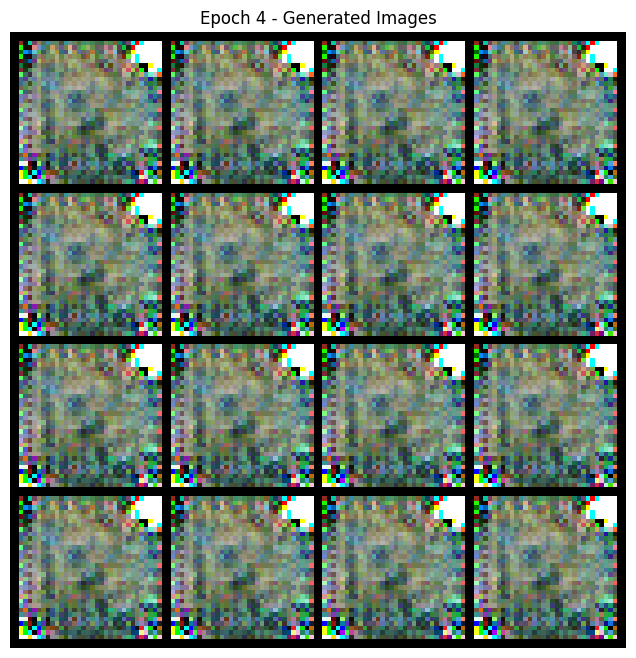

[Epoch 4/5] [Batch 0/1563] [D loss: 0.0012] [G loss: -0.3906]
[Epoch 4/5] [Batch 100/1563] [D loss: 0.0006] [G loss: -0.3904]
[Epoch 4/5] [Batch 200/1563] [D loss: 0.0001] [G loss: -0.3905]
[Epoch 4/5] [Batch 300/1563] [D loss: 0.0011] [G loss: -0.3906]
[Epoch 4/5] [Batch 400/1563] [D loss: 0.0005] [G loss: -0.3905]
[Epoch 4/5] [Batch 500/1563] [D loss: 0.0000] [G loss: -0.3906]
[Epoch 4/5] [Batch 600/1563] [D loss: 0.0000] [G loss: -0.3905]
[Epoch 4/5] [Batch 700/1563] [D loss: 0.0002] [G loss: -0.3904]
[Epoch 4/5] [Batch 800/1563] [D loss: 0.0010] [G loss: -0.3905]
[Epoch 4/5] [Batch 900/1563] [D loss: 0.0001] [G loss: -0.3904]
[Epoch 4/5] [Batch 1000/1563] [D loss: -0.0000] [G loss: -0.3904]
[Epoch 4/5] [Batch 1100/1563] [D loss: 0.0003] [G loss: -0.3905]
[Epoch 4/5] [Batch 1200/1563] [D loss: -0.0001] [G loss: -0.3904]
[Epoch 4/5] [Batch 1300/1563] [D loss: -0.0001] [G loss: -0.3903]
[Epoch 4/5] [Batch 1400/1563] [D loss: -0.0001] [G loss: -0.3904]
[Epoch 4/5] [Batch 1500/1563] [D 

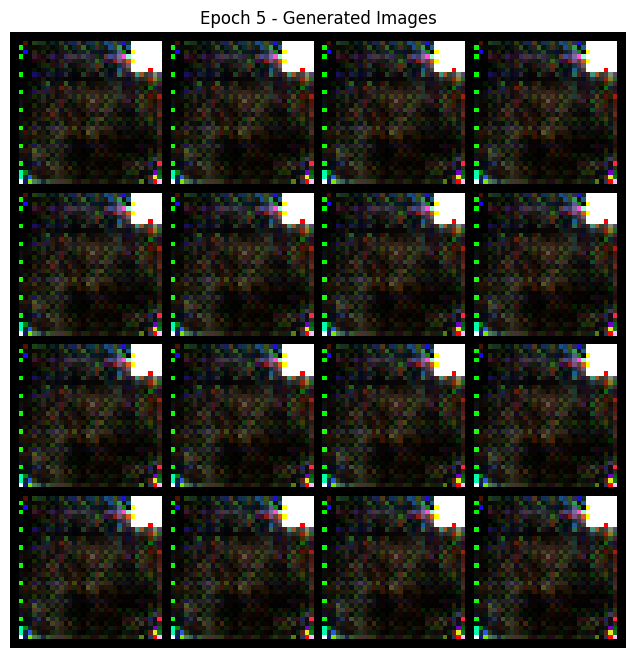

In [ ]:
# base code modified with GPT for robustness and loss tracking

# Lists to store losses
d_losses = []
g_losses = []

# Training Loop
for epoch in range(n_epochs):
    d_loss_epoch = 0.0  # Track total D loss per epoch
    g_loss_epoch = 0.0  # Track total G loss per epoch
    num_batches = len(dataloader)

    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator multiple times
        for _ in range(d_updates):
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())
            gp = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            d_loss = (
                -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            )

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train Generator less frequently
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Accumulate losses
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        # Print stats every 100 batches
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Average losses for the epoch
    d_loss_epoch /= num_batches
    g_loss_epoch /= num_batches
    d_losses.append(d_loss_epoch)
    g_losses.append(g_loss_epoch)

    # Generate and display images at the end of each epoch
    with torch.no_grad():
        z = torch.zeros(16, latent_dim, device=device)  # Fixed noise for consistency
        generated_imgs = generator(z).cpu()
        generated_imgs = (generated_imgs + 1) / 2  # Rescale to [0, 1]

        grid = torchvision.utils.make_grid(generated_imgs, nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))  # Convert CHW to HWC
        plt.axis("off")
        plt.title(f"Epoch {epoch + 1} - Generated Images")
        plt.show()


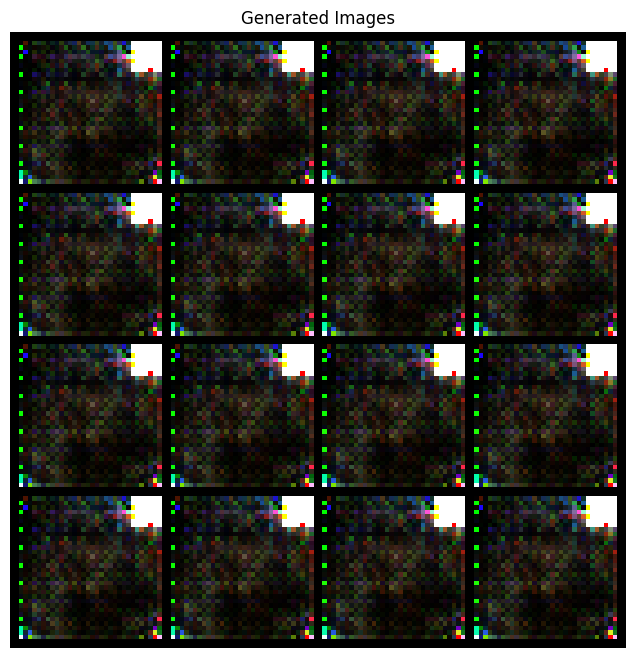

In [ ]:
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    generated_imgs = generator(z).cpu()
    generated_imgs = (generated_imgs + 1) / 2  # Rescale to [0, 1]

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()


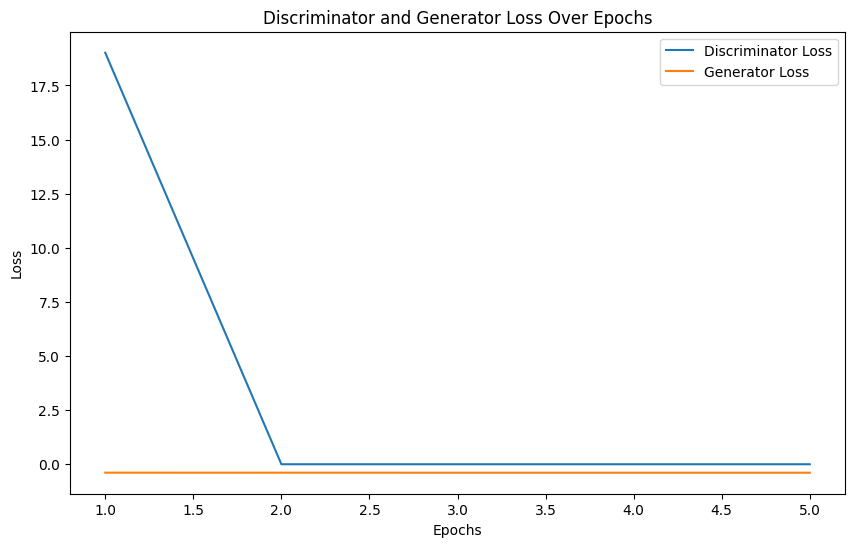

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), d_losses, label="Discriminator Loss")
plt.plot(range(1, n_epochs + 1), g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss Over Epochs")
plt.legend()
plt.show()


Loss Behavior:

1. The discriminator loss starts high and drops quickly to near-zero, indicating the discriminator saturates and cannot distinguish between real and generated images.
2. The generator loss remains constant and close to 0, positve, meaning the generator is stuck producing repetitive outputs.
Generated Images:

All generated images are nearly identical, confirming severe mode collapse.

Next steps:
Fixing mode collapse

In [ ]:
# Define hyperparameters
batch_size = 64
image_size = 32
latent_dim = 100
lr = 0.0002
beta1 = 0.5
epochs = 20

In [ ]:
# Transformations for CIFAR-10
# Normalize images to [-1, 1] to match typical GAN input range
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        ),  # Normalize R, G, B channels
    ]
)

# Load CIFAR-10 dataset
cifar10_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# Replace MNIST DataLoader with CIFAR-10 DataLoader
data_loader = DataLoader(dataset=cifar10_dataset, batch_size=batch_size, shuffle=True)

# Test: Iterate through the DataLoader
for images, labels in data_loader:
    print(f"Batch image shape: {images.shape}")  # (batch_size, 3, 32, 32)
    print(f"Batch label shape: {labels.shape}")  # (batch_size,)
    break


Files already downloaded and verified
Batch image shape: torch.Size([64, 3, 32, 32])
Batch label shape: torch.Size([64])


Epoch [0/20], Step [0/782], D Loss: 1.2946, G Loss: 1.5477
Epoch [0/20], Step [100/782], D Loss: 0.7809, G Loss: 8.7440
Epoch [0/20], Step [200/782], D Loss: 0.0715, G Loss: 6.3896
Epoch [0/20], Step [300/782], D Loss: 1.5072, G Loss: 6.5936
Epoch [0/20], Step [400/782], D Loss: 0.4297, G Loss: 2.2423
Epoch [0/20], Step [500/782], D Loss: 0.1760, G Loss: 3.9668
Epoch [0/20], Step [600/782], D Loss: 0.0566, G Loss: 4.7150
Epoch [0/20], Step [700/782], D Loss: 0.0678, G Loss: 4.6219


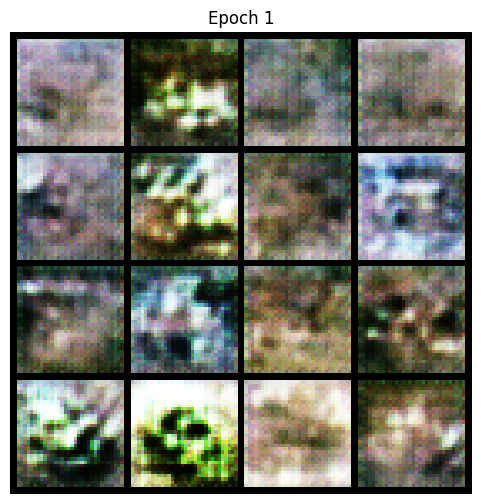

Epoch [1/20], Step [0/782], D Loss: 0.2616, G Loss: 3.7252
Epoch [1/20], Step [100/782], D Loss: 0.5683, G Loss: 4.4569
Epoch [1/20], Step [200/782], D Loss: 0.1166, G Loss: 3.6461
Epoch [1/20], Step [300/782], D Loss: 0.1824, G Loss: 3.4959
Epoch [1/20], Step [400/782], D Loss: 0.5138, G Loss: 1.8573
Epoch [1/20], Step [500/782], D Loss: 0.2549, G Loss: 2.0303
Epoch [1/20], Step [600/782], D Loss: 0.4096, G Loss: 2.3387
Epoch [1/20], Step [700/782], D Loss: 0.1635, G Loss: 3.0758


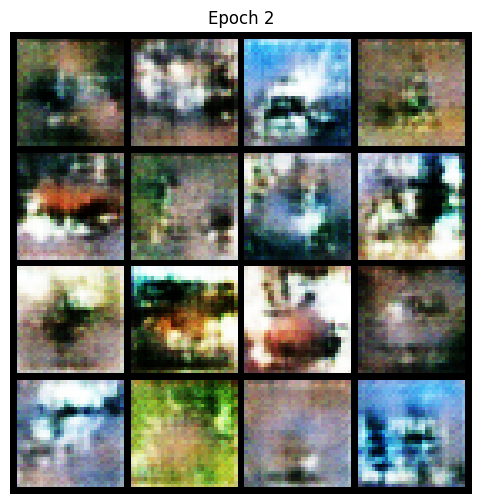

Epoch [2/20], Step [0/782], D Loss: 0.0516, G Loss: 4.4915
Epoch [2/20], Step [100/782], D Loss: 0.1383, G Loss: 3.3834
Epoch [2/20], Step [200/782], D Loss: 0.1074, G Loss: 6.8665
Epoch [2/20], Step [300/782], D Loss: 0.0069, G Loss: 6.4742
Epoch [2/20], Step [400/782], D Loss: 0.4732, G Loss: 3.2315
Epoch [2/20], Step [500/782], D Loss: 0.0570, G Loss: 4.6472
Epoch [2/20], Step [600/782], D Loss: 2.4243, G Loss: 9.6940
Epoch [2/20], Step [700/782], D Loss: 0.0558, G Loss: 4.0043


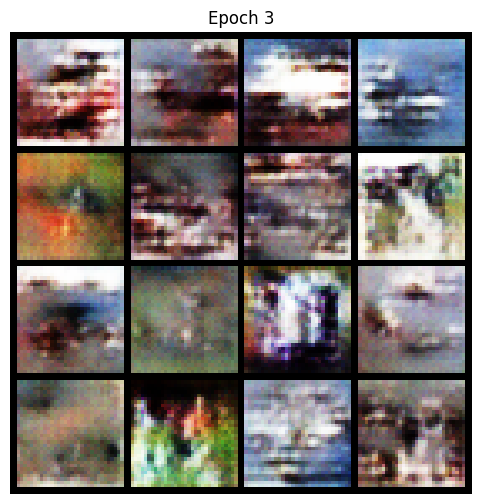

Epoch [3/20], Step [0/782], D Loss: 0.0182, G Loss: 8.5825
Epoch [3/20], Step [100/782], D Loss: 1.1042, G Loss: 8.3840
Epoch [3/20], Step [200/782], D Loss: 0.6057, G Loss: 2.0231
Epoch [3/20], Step [300/782], D Loss: 0.2139, G Loss: 3.0586
Epoch [3/20], Step [400/782], D Loss: 0.3495, G Loss: 3.7963
Epoch [3/20], Step [500/782], D Loss: 0.0896, G Loss: 4.1815
Epoch [3/20], Step [600/782], D Loss: 0.6693, G Loss: 2.4564
Epoch [3/20], Step [700/782], D Loss: 0.5262, G Loss: 4.4001


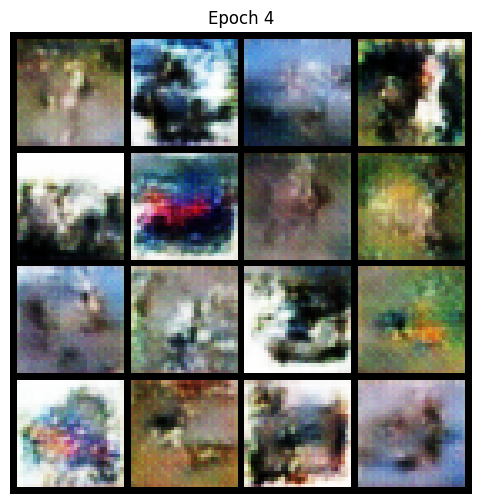

Epoch [4/20], Step [0/782], D Loss: 1.3430, G Loss: 8.1358
Epoch [4/20], Step [100/782], D Loss: 0.0627, G Loss: 7.7826
Epoch [4/20], Step [200/782], D Loss: 2.1906, G Loss: 5.1157
Epoch [4/20], Step [300/782], D Loss: 0.2377, G Loss: 3.8864
Epoch [4/20], Step [400/782], D Loss: 0.1221, G Loss: 3.6344
Epoch [4/20], Step [500/782], D Loss: 1.2085, G Loss: 0.8544
Epoch [4/20], Step [600/782], D Loss: 0.2870, G Loss: 4.1101
Epoch [4/20], Step [700/782], D Loss: 0.1215, G Loss: 3.7097


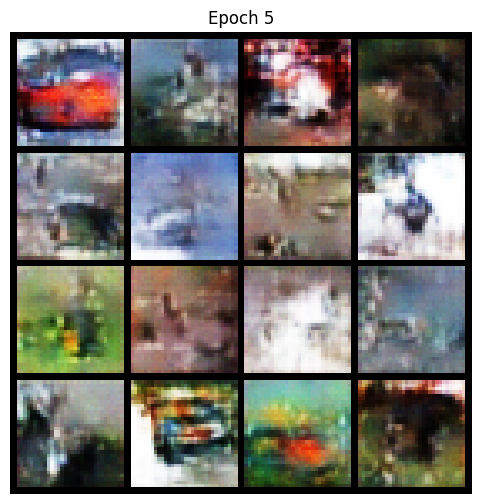

Epoch [5/20], Step [0/782], D Loss: 0.2286, G Loss: 2.4618
Epoch [5/20], Step [100/782], D Loss: 0.1408, G Loss: 5.7150
Epoch [5/20], Step [200/782], D Loss: 1.8349, G Loss: 2.1506
Epoch [5/20], Step [300/782], D Loss: 0.0388, G Loss: 6.4416
Epoch [5/20], Step [400/782], D Loss: 0.1722, G Loss: 3.1011
Epoch [5/20], Step [500/782], D Loss: 0.9778, G Loss: 5.5494
Epoch [5/20], Step [600/782], D Loss: 0.0344, G Loss: 6.5275
Epoch [5/20], Step [700/782], D Loss: 0.4603, G Loss: 2.4231


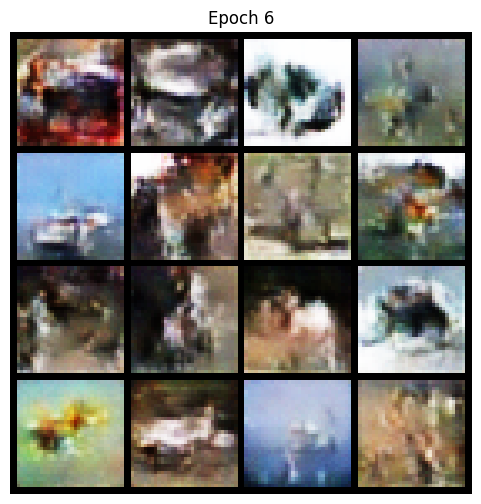

Epoch [6/20], Step [0/782], D Loss: 0.3280, G Loss: 2.8044
Epoch [6/20], Step [100/782], D Loss: 0.2971, G Loss: 2.8592
Epoch [6/20], Step [200/782], D Loss: 0.3974, G Loss: 2.9356
Epoch [6/20], Step [300/782], D Loss: 0.8077, G Loss: 5.5836
Epoch [6/20], Step [400/782], D Loss: 0.0882, G Loss: 3.9658
Epoch [6/20], Step [500/782], D Loss: 0.3449, G Loss: 3.5821
Epoch [6/20], Step [600/782], D Loss: 0.1158, G Loss: 4.2012
Epoch [6/20], Step [700/782], D Loss: 0.2653, G Loss: 3.5440


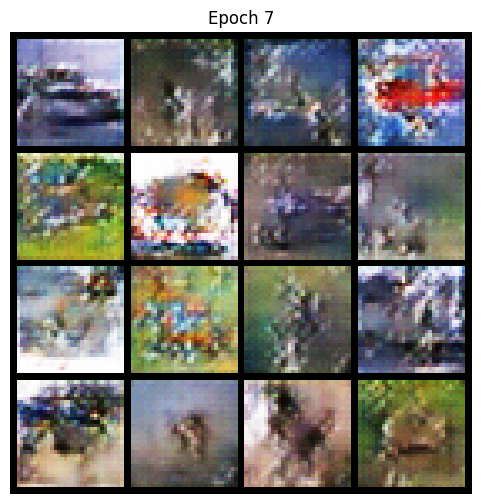

Epoch [7/20], Step [0/782], D Loss: 0.0129, G Loss: 7.7881
Epoch [7/20], Step [100/782], D Loss: 0.3746, G Loss: 2.4218
Epoch [7/20], Step [200/782], D Loss: 0.0608, G Loss: 3.9857
Epoch [7/20], Step [300/782], D Loss: 0.6003, G Loss: 1.3915
Epoch [7/20], Step [400/782], D Loss: 0.0562, G Loss: 6.0716
Epoch [7/20], Step [500/782], D Loss: 0.2161, G Loss: 3.7504
Epoch [7/20], Step [600/782], D Loss: 0.6183, G Loss: 6.7741
Epoch [7/20], Step [700/782], D Loss: 0.0693, G Loss: 4.2091


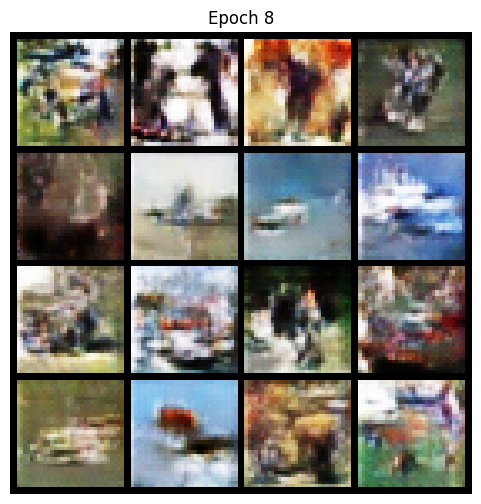

Epoch [8/20], Step [0/782], D Loss: 0.1248, G Loss: 5.1810
Epoch [8/20], Step [100/782], D Loss: 0.1848, G Loss: 3.0557
Epoch [8/20], Step [200/782], D Loss: 0.0989, G Loss: 3.9886
Epoch [8/20], Step [300/782], D Loss: 0.2133, G Loss: 4.6987
Epoch [8/20], Step [400/782], D Loss: 0.0120, G Loss: 5.2158
Epoch [8/20], Step [500/782], D Loss: 0.2635, G Loss: 3.2964
Epoch [8/20], Step [600/782], D Loss: 0.4077, G Loss: 3.0616
Epoch [8/20], Step [700/782], D Loss: 0.0440, G Loss: 7.4034


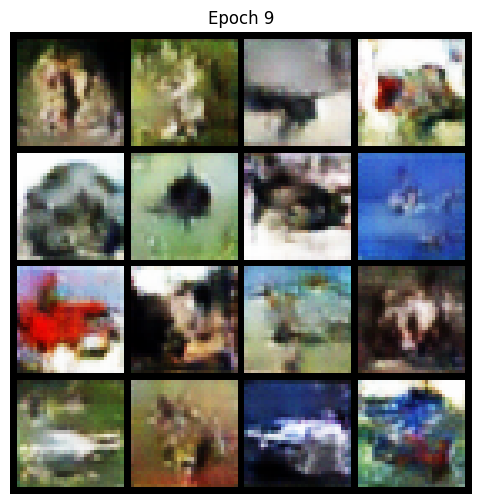

Epoch [9/20], Step [0/782], D Loss: 0.1384, G Loss: 8.2976
Epoch [9/20], Step [100/782], D Loss: 0.5953, G Loss: 3.0679
Epoch [9/20], Step [200/782], D Loss: 0.0501, G Loss: 6.6527
Epoch [9/20], Step [300/782], D Loss: 0.7238, G Loss: 1.7705
Epoch [9/20], Step [400/782], D Loss: 0.0229, G Loss: 6.2020
Epoch [9/20], Step [500/782], D Loss: 0.0494, G Loss: 5.1988
Epoch [9/20], Step [600/782], D Loss: 0.3366, G Loss: 4.3750
Epoch [9/20], Step [700/782], D Loss: 0.2497, G Loss: 4.2731


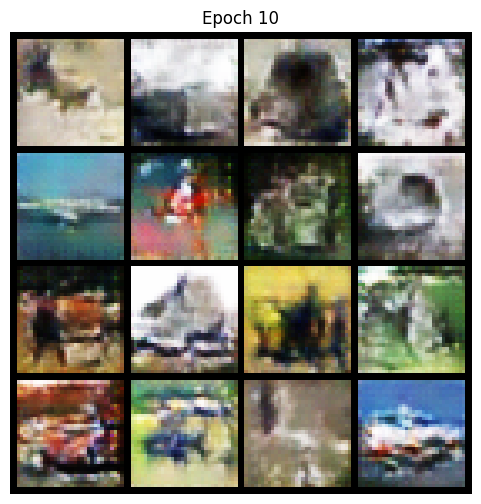

Epoch [10/20], Step [0/782], D Loss: 0.0248, G Loss: 5.6672
Epoch [10/20], Step [100/782], D Loss: 0.3699, G Loss: 2.7573
Epoch [10/20], Step [200/782], D Loss: 0.0470, G Loss: 7.3986
Epoch [10/20], Step [300/782], D Loss: 0.6225, G Loss: 2.2822
Epoch [10/20], Step [400/782], D Loss: 0.0476, G Loss: 4.6669
Epoch [10/20], Step [500/782], D Loss: 0.0509, G Loss: 5.7471
Epoch [10/20], Step [600/782], D Loss: 0.0469, G Loss: 8.4456
Epoch [10/20], Step [700/782], D Loss: 0.2950, G Loss: 3.3036


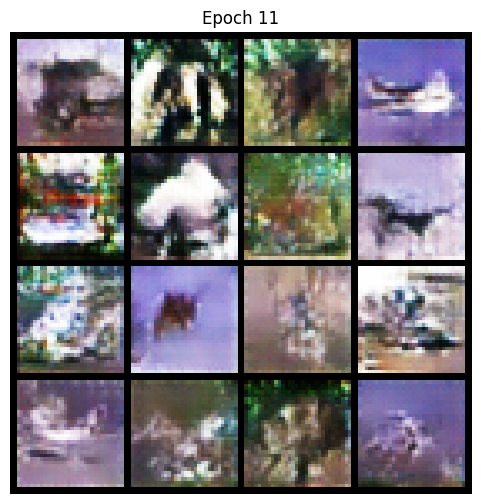

Epoch [11/20], Step [0/782], D Loss: 0.0798, G Loss: 4.0831
Epoch [11/20], Step [100/782], D Loss: 0.1781, G Loss: 3.9685
Epoch [11/20], Step [200/782], D Loss: 0.0386, G Loss: 4.9731
Epoch [11/20], Step [300/782], D Loss: 0.0633, G Loss: 5.4474
Epoch [11/20], Step [400/782], D Loss: 0.4452, G Loss: 2.8137
Epoch [11/20], Step [500/782], D Loss: 0.6500, G Loss: 2.6309
Epoch [11/20], Step [600/782], D Loss: 0.1345, G Loss: 3.9128
Epoch [11/20], Step [700/782], D Loss: 0.1027, G Loss: 3.8537


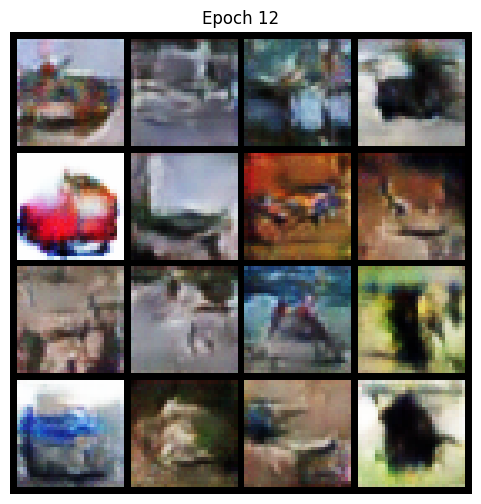

Epoch [12/20], Step [0/782], D Loss: 0.1012, G Loss: 3.7334
Epoch [12/20], Step [100/782], D Loss: 0.5883, G Loss: 3.2806
Epoch [12/20], Step [200/782], D Loss: 0.1072, G Loss: 3.1812
Epoch [12/20], Step [300/782], D Loss: 0.0247, G Loss: 5.7081
Epoch [12/20], Step [400/782], D Loss: 0.0549, G Loss: 3.9404
Epoch [12/20], Step [500/782], D Loss: 0.0437, G Loss: 6.3666
Epoch [12/20], Step [600/782], D Loss: 0.1326, G Loss: 3.4969
Epoch [12/20], Step [700/782], D Loss: 0.0162, G Loss: 9.2944


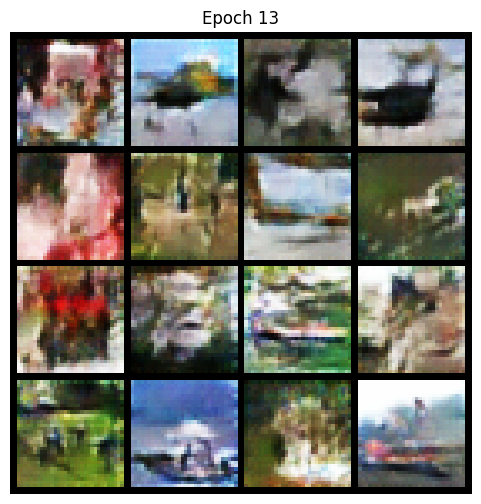

Epoch [13/20], Step [0/782], D Loss: 0.5580, G Loss: 4.0883
Epoch [13/20], Step [100/782], D Loss: 0.0951, G Loss: 4.3306
Epoch [13/20], Step [200/782], D Loss: 1.1646, G Loss: 1.1458
Epoch [13/20], Step [300/782], D Loss: 0.1360, G Loss: 3.4820
Epoch [13/20], Step [400/782], D Loss: 0.2088, G Loss: 2.9085
Epoch [13/20], Step [500/782], D Loss: 0.0354, G Loss: 6.8657
Epoch [13/20], Step [600/782], D Loss: 0.0377, G Loss: 7.4053
Epoch [13/20], Step [700/782], D Loss: 0.3599, G Loss: 3.9231


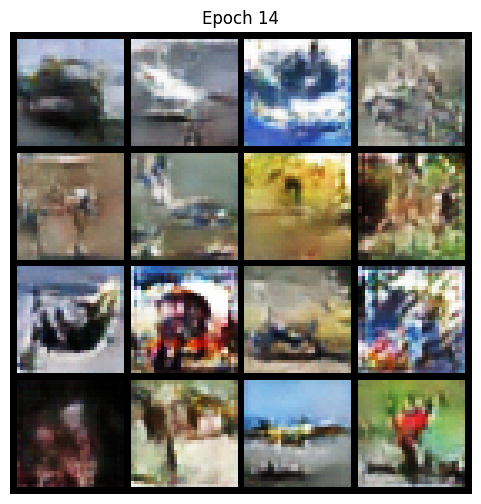

Epoch [14/20], Step [0/782], D Loss: 0.1178, G Loss: 3.5757
Epoch [14/20], Step [100/782], D Loss: 0.2223, G Loss: 4.0701
Epoch [14/20], Step [200/782], D Loss: 0.1150, G Loss: 3.3460
Epoch [14/20], Step [300/782], D Loss: 0.3199, G Loss: 4.4290
Epoch [14/20], Step [400/782], D Loss: 0.0653, G Loss: 8.3461
Epoch [14/20], Step [500/782], D Loss: 0.1754, G Loss: 3.2200
Epoch [14/20], Step [600/782], D Loss: 0.5359, G Loss: 4.3045
Epoch [14/20], Step [700/782], D Loss: 0.5109, G Loss: 3.9197


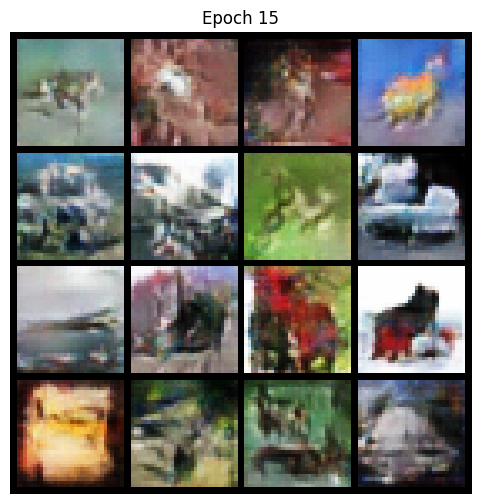

Epoch [15/20], Step [0/782], D Loss: 0.8178, G Loss: 3.1075
Epoch [15/20], Step [100/782], D Loss: 0.3286, G Loss: 4.8496
Epoch [15/20], Step [200/782], D Loss: 0.0964, G Loss: 4.5844
Epoch [15/20], Step [300/782], D Loss: 0.0540, G Loss: 4.4078
Epoch [15/20], Step [400/782], D Loss: 0.1262, G Loss: 4.0395
Epoch [15/20], Step [500/782], D Loss: 0.1562, G Loss: 4.2025
Epoch [15/20], Step [600/782], D Loss: 0.0493, G Loss: 5.6302
Epoch [15/20], Step [700/782], D Loss: 0.1028, G Loss: 7.4035


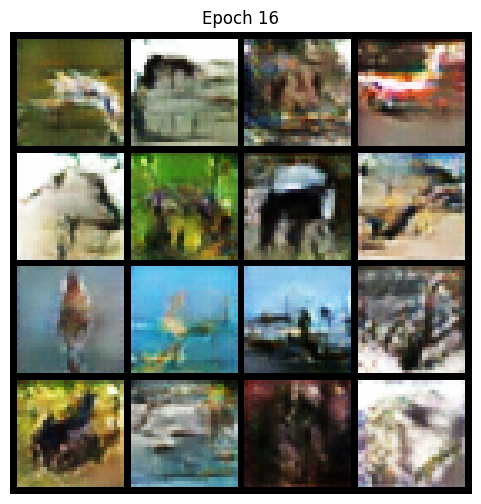

Epoch [16/20], Step [0/782], D Loss: 0.7765, G Loss: 5.5425
Epoch [16/20], Step [100/782], D Loss: 0.0347, G Loss: 7.0717
Epoch [16/20], Step [200/782], D Loss: 3.4133, G Loss: 2.1218
Epoch [16/20], Step [300/782], D Loss: 0.0904, G Loss: 4.6527
Epoch [16/20], Step [400/782], D Loss: 5.0347, G Loss: 7.6684
Epoch [16/20], Step [500/782], D Loss: 0.4525, G Loss: 1.2775
Epoch [16/20], Step [600/782], D Loss: 0.0300, G Loss: 6.2901
Epoch [16/20], Step [700/782], D Loss: 0.2033, G Loss: 4.1808


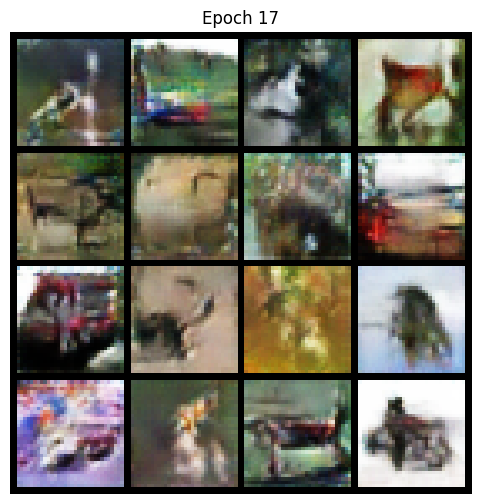

Epoch [17/20], Step [0/782], D Loss: 0.0431, G Loss: 6.2991
Epoch [17/20], Step [100/782], D Loss: 0.3450, G Loss: 4.1842
Epoch [17/20], Step [200/782], D Loss: 0.0224, G Loss: 6.6736
Epoch [17/20], Step [300/782], D Loss: 0.2433, G Loss: 5.8489
Epoch [17/20], Step [400/782], D Loss: 0.4162, G Loss: 5.6842
Epoch [17/20], Step [500/782], D Loss: 0.1382, G Loss: 3.0882
Epoch [17/20], Step [600/782], D Loss: 0.3222, G Loss: 3.3635
Epoch [17/20], Step [700/782], D Loss: 0.2479, G Loss: 3.4881


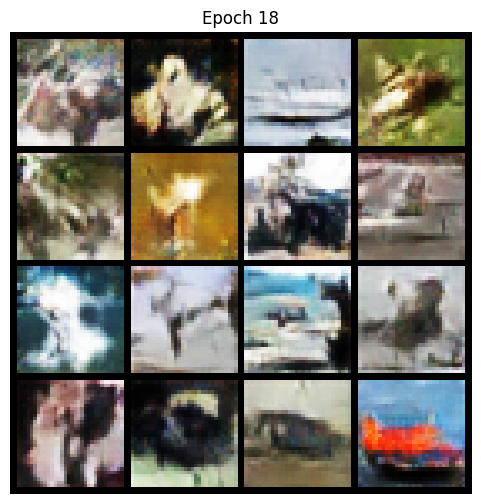

Epoch [18/20], Step [0/782], D Loss: 0.0619, G Loss: 4.0172
Epoch [18/20], Step [100/782], D Loss: 0.0354, G Loss: 4.3779
Epoch [18/20], Step [200/782], D Loss: 0.1201, G Loss: 4.3748
Epoch [18/20], Step [300/782], D Loss: 2.1004, G Loss: 1.4589
Epoch [18/20], Step [400/782], D Loss: 0.0748, G Loss: 3.7885
Epoch [18/20], Step [500/782], D Loss: 0.0385, G Loss: 6.2807
Epoch [18/20], Step [600/782], D Loss: 0.1825, G Loss: 3.9627
Epoch [18/20], Step [700/782], D Loss: 0.1494, G Loss: 3.3716


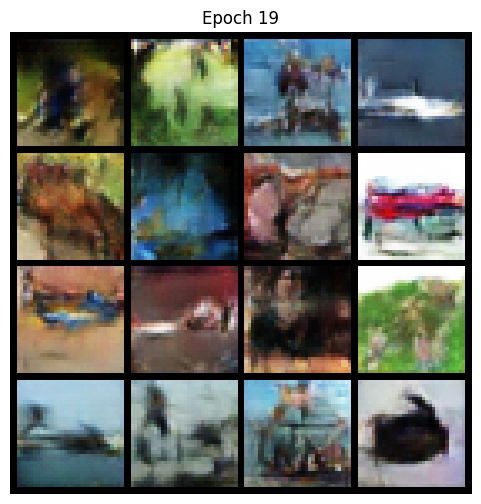

Epoch [19/20], Step [0/782], D Loss: 0.0461, G Loss: 4.7056
Epoch [19/20], Step [100/782], D Loss: 0.1435, G Loss: 3.1895
Epoch [19/20], Step [200/782], D Loss: 0.1605, G Loss: 4.0060
Epoch [19/20], Step [300/782], D Loss: 0.1135, G Loss: 3.3300
Epoch [19/20], Step [400/782], D Loss: 0.3253, G Loss: 4.9306
Epoch [19/20], Step [500/782], D Loss: 0.2136, G Loss: 3.7958
Epoch [19/20], Step [600/782], D Loss: 0.0438, G Loss: 4.4023
Epoch [19/20], Step [700/782], D Loss: 0.1311, G Loss: 4.2826


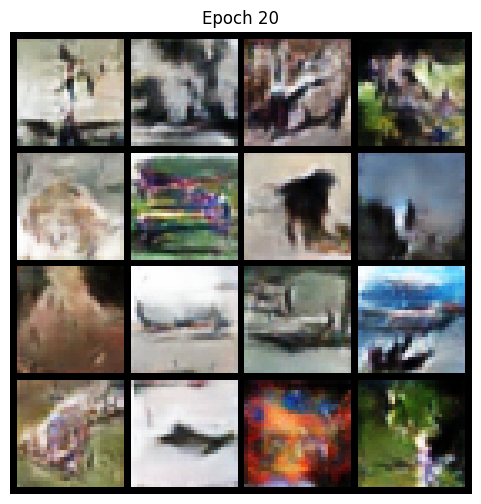

In [ ]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),  # Reshape to (256, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),  # Output values in range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid(),  # Output probability of being real
        )

    def forward(self, x):
        return self.model(x)


# Initialize models, optimizers, and loss function
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        # Fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Try to fool discriminator
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}], Step [{i}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}"
            )

    # Save generated images at the end of each epoch
    with torch.no_grad():
        noise = torch.randn(16, latent_dim).to(device)
        fake_images = generator(noise).cpu()
        fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]
        grid = torchvision.utils.make_grid(fake_images, nrow=4)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Epoch {epoch + 1}")
        plt.show()


## VAE on CIFAR-10

In [ ]:
# Hyperparameters
batch_size = 64
latent_dim = 100
lr = 0.001
epochs = 15

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
images = (images - images.min()) / (images.max() - images.min())

Epoch [0/15], Step [0/782], Loss: 0.4430
Epoch [0/15], Step [100/782], Loss: 0.2408
Epoch [0/15], Step [200/782], Loss: 0.2720
Epoch [0/15], Step [300/782], Loss: 0.2526
Epoch [0/15], Step [400/782], Loss: 0.2569
Epoch [0/15], Step [500/782], Loss: 0.2339
Epoch [0/15], Step [600/782], Loss: 0.2461
Epoch [0/15], Step [700/782], Loss: 0.2282


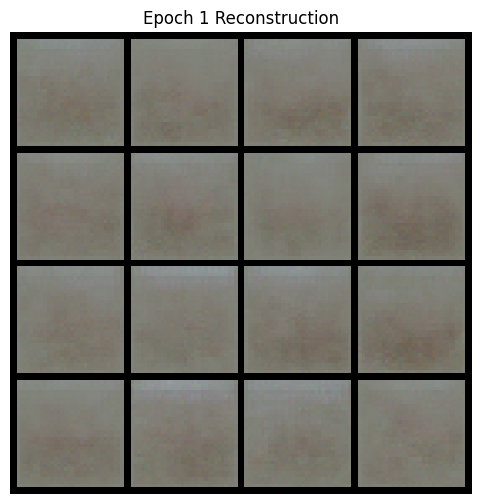

Epoch [1/15], Step [0/782], Loss: 0.2197
Epoch [1/15], Step [100/782], Loss: 0.2552
Epoch [1/15], Step [200/782], Loss: 0.2429
Epoch [1/15], Step [300/782], Loss: 0.2442
Epoch [1/15], Step [400/782], Loss: 0.2536
Epoch [1/15], Step [500/782], Loss: 0.2536
Epoch [1/15], Step [600/782], Loss: 0.2541
Epoch [1/15], Step [700/782], Loss: 0.2543


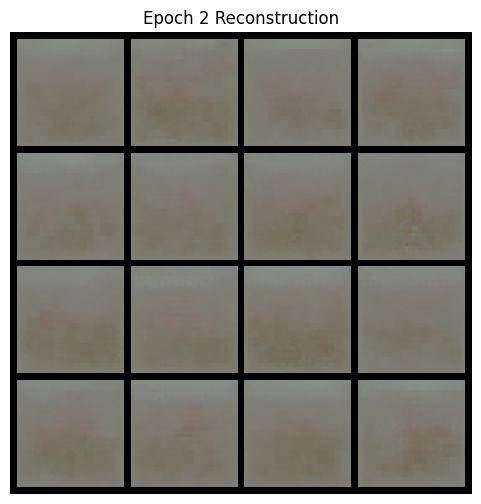

Epoch [2/15], Step [0/782], Loss: 0.2325
Epoch [2/15], Step [100/782], Loss: 0.2652
Epoch [2/15], Step [200/782], Loss: 0.2593
Epoch [2/15], Step [300/782], Loss: 0.2504
Epoch [2/15], Step [400/782], Loss: 0.2356
Epoch [2/15], Step [500/782], Loss: 0.2386
Epoch [2/15], Step [600/782], Loss: 0.2439
Epoch [2/15], Step [700/782], Loss: 0.2509


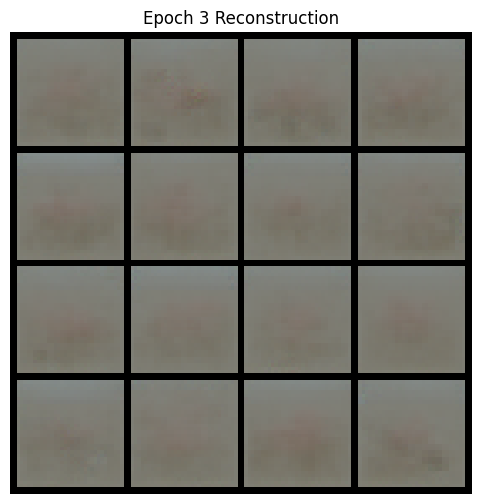

Epoch [3/15], Step [0/782], Loss: 0.2632
Epoch [3/15], Step [100/782], Loss: 0.2695
Epoch [3/15], Step [200/782], Loss: 0.2366
Epoch [3/15], Step [300/782], Loss: 0.2486
Epoch [3/15], Step [400/782], Loss: 0.2365
Epoch [3/15], Step [500/782], Loss: 0.2461
Epoch [3/15], Step [600/782], Loss: 0.2468
Epoch [3/15], Step [700/782], Loss: 0.2424


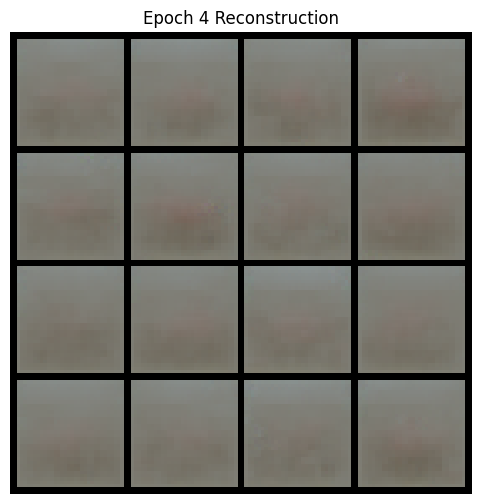

Epoch [4/15], Step [0/782], Loss: 0.2492
Epoch [4/15], Step [100/782], Loss: 0.2712
Epoch [4/15], Step [200/782], Loss: 0.2563
Epoch [4/15], Step [300/782], Loss: 0.2711
Epoch [4/15], Step [400/782], Loss: 0.2456
Epoch [4/15], Step [500/782], Loss: 0.2322
Epoch [4/15], Step [600/782], Loss: 0.2350
Epoch [4/15], Step [700/782], Loss: 0.2490


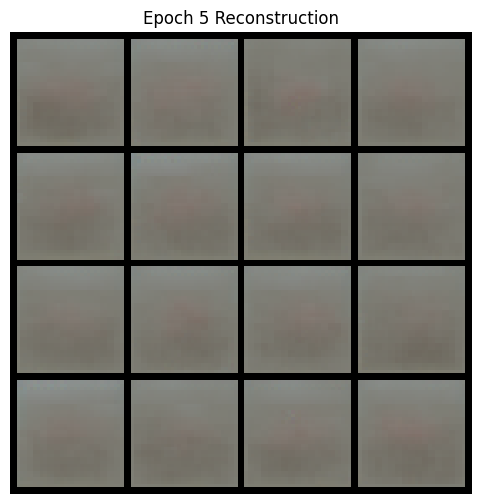

Epoch [5/15], Step [0/782], Loss: 0.2465
Epoch [5/15], Step [100/782], Loss: 0.2498
Epoch [5/15], Step [200/782], Loss: 0.2841
Epoch [5/15], Step [300/782], Loss: 0.2370
Epoch [5/15], Step [400/782], Loss: 0.2440
Epoch [5/15], Step [500/782], Loss: 0.2376
Epoch [5/15], Step [600/782], Loss: 0.2499
Epoch [5/15], Step [700/782], Loss: 0.2599


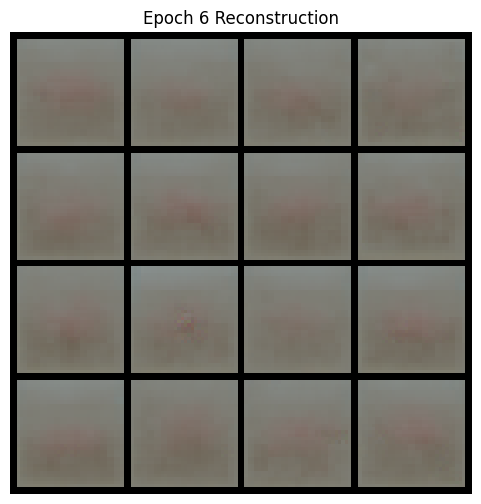

Epoch [6/15], Step [0/782], Loss: 0.2170
Epoch [6/15], Step [100/782], Loss: 0.2318
Epoch [6/15], Step [200/782], Loss: 0.2611
Epoch [6/15], Step [300/782], Loss: 0.2555
Epoch [6/15], Step [400/782], Loss: 0.2485
Epoch [6/15], Step [500/782], Loss: 0.2526
Epoch [6/15], Step [600/782], Loss: 0.2566
Epoch [6/15], Step [700/782], Loss: 0.2504


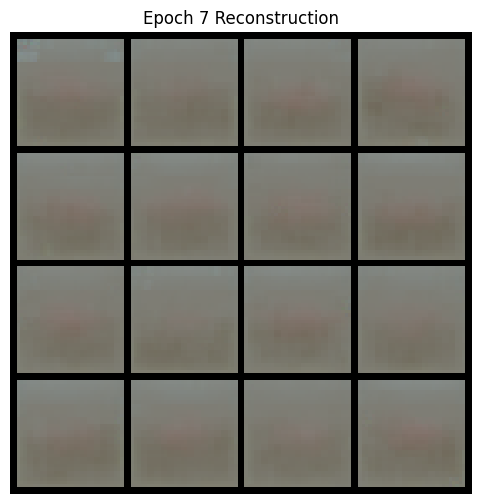

Epoch [7/15], Step [0/782], Loss: 0.2278
Epoch [7/15], Step [100/782], Loss: 0.2559
Epoch [7/15], Step [200/782], Loss: 0.2599
Epoch [7/15], Step [300/782], Loss: 0.2730
Epoch [7/15], Step [400/782], Loss: 0.2505
Epoch [7/15], Step [500/782], Loss: 0.2206
Epoch [7/15], Step [600/782], Loss: 0.2226
Epoch [7/15], Step [700/782], Loss: 0.2399


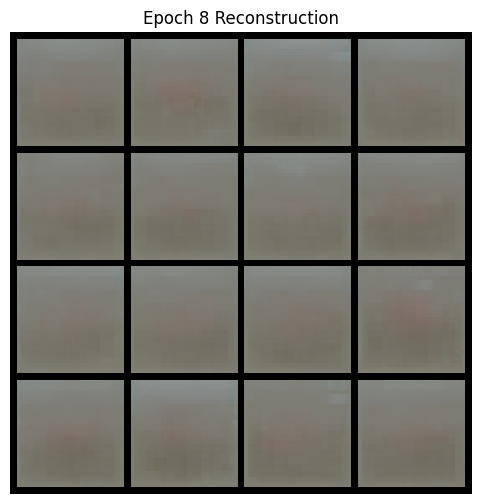

Epoch [8/15], Step [0/782], Loss: 0.2549
Epoch [8/15], Step [100/782], Loss: 0.2840
Epoch [8/15], Step [200/782], Loss: 0.2431
Epoch [8/15], Step [300/782], Loss: 0.2438
Epoch [8/15], Step [400/782], Loss: 0.2321
Epoch [8/15], Step [500/782], Loss: 0.2539
Epoch [8/15], Step [600/782], Loss: 0.2501
Epoch [8/15], Step [700/782], Loss: 0.2210


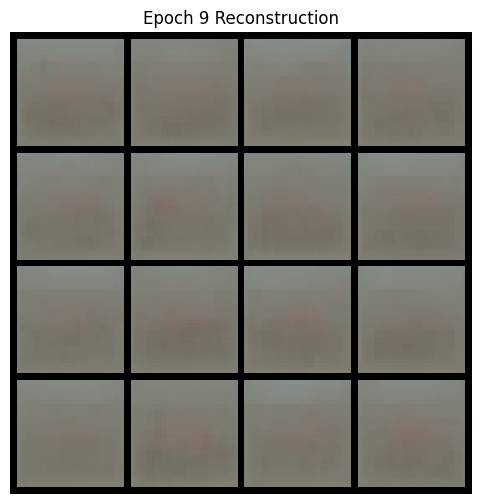

Epoch [9/15], Step [0/782], Loss: 0.2552
Epoch [9/15], Step [100/782], Loss: 0.2570
Epoch [9/15], Step [200/782], Loss: 0.2400
Epoch [9/15], Step [300/782], Loss: 0.2509
Epoch [9/15], Step [400/782], Loss: 0.2337
Epoch [9/15], Step [500/782], Loss: 0.2252
Epoch [9/15], Step [600/782], Loss: 0.2561


KeyboardInterrupt: 

In [ ]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Log variance

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        return mu, logvar

    def decode(self, z):
        decoded_input = self.decoder_input(z)
        decoded = self.decoder(decoded_input)
        return decoded

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar


# Initialize the model, optimizer, and loss function
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)
criterion = nn.MSELoss()


# Loss function with KL divergence
def vae_loss_function(reconstructed, original, mu, logvar):
    reconstruction_loss = criterion(reconstructed, original)
    kl_divergence = (
        -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / original.size(0)
    )
    return reconstruction_loss + kl_divergence


# Training loop
for epoch in range(epochs):
    vae.train()
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructed, mu, logvar = vae(images)
        loss = vae_loss_function(reconstructed, images, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}], Step [{i}/{len(data_loader)}], Loss: {loss.item():.4f}"
            )

    # Display reconstructed images after each epoch
    vae.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed, _, _ = vae(images)
        images = (images + 1) / 2
        reconstructed = (reconstructed + 1) / 2
        grid = torchvision.utils.make_grid(reconstructed[:16].cpu(), nrow=4)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Epoch {epoch + 1} Reconstruction")
        plt.show()

# Generate new images
vae.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    generated_images = vae.decode(z)
    generated_images = (generated_images + 1) / 2
    grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()


Clearly, the model does not manage to produce qualitative images so we stopped the training before and did not have the time to dig deeper to fix the architecture of the model.

# Metrics to Evaluate Mode Collapse in GANs

---

## 1. **Frechet Inception Distance (FID)**
- **Description**: 
    FID compares the **feature statistics** (mean and covariance) of generated images to those of real images using activations from a pre-trained **InceptionV3** network.
- **Formula**:
$$
FID(p, q) = ||\mu_p - \mu_q||_2^2 + Tr(\Sigma_p + \Sigma_q - 2(\Sigma_p\Sigma_q)^{1/2})
$$
Where:
- $\mu_p$, $\Sigma_p$: Mean and covariance of real image features.
- $\mu_q$, $\Sigma_q$: Mean and covariance of generated image features.

- **Usefulness**:
    - Mode collapse typically leads to poor diversity.
    - High FID values indicate poor diversity and lower image quality.
    - Lower FID values indicate the generator produces realistic and diverse images.

- **Implementation**:
    - Use libraries:
      - `torch-fidelity`
      - `torchmetrics`

---

## 2. **Inception Score (IS)**
- **Description**:
    The **Inception Score** uses a pre-trained **InceptionV3** model to evaluate the diversity and quality of generated images. It measures:
    1. How well the model classifies generated images (confidence of predictions).
    2. How diverse the generated images are across classes.

- **Formula**:
$$
IS = \exp\left(\mathbb{E}_x \left[ KL\left( p(y|x) || p(y) \right) \right]\right)
$$
Where:
- $p(y|x)$: Predicted label distribution for a generated image $x$.
- $p(y)$: Marginal distribution of all generated images.

- **Usefulness**:
    - Mode collapse results in low **diversity** and often lowers the Inception Score.
    - **Higher IS** indicates better diversity and quality, but it does not guarantee the absence of mode collapse.

---

## 3. **Mode Entropy (Shannon Entropy)**
- **Description**:
    Mode entropy measures the **unpredictability** of the mode (or class) distribution in the generated samples. It uses the entropy of the predicted class probabilities:
$$
H(p) = -\sum_i p_i \log(p_i)
$$
Where $p_i $ is the probability distribution over classes.

- **Usefulness**:
    - **Low entropy** suggests mode collapse: the generator produces only a few classes.
    - **High entropy** indicates the generator is producing a wide variety of samples.

---

## Summary of Metrics:
| Metric                   | Key Focus                   | Mode Collapse Indicator         |
|--------------------------|-----------------------------|---------------------------------|
| **FID**                  | Realism + Diversity         | High FID indicates collapse     |
| **Inception Score (IS)** | Class diversity + quality   | Low IS indicates collapse       |
| **Mode Entropy**         | Class unpredictability      | Low entropy indicates collapse  |

---

## References:
1. **Frechet Inception Distance**: [Original Paper](https://arxiv.org/abs/1706.08500)
2. **Inception Score**: [Original Paper](https://arxiv.org/abs/1606.03498)
3. Mode Collapse Analysis: [IEEE HPEC 2018 Paper](https://ieee-hpec.org/2018/2018program/index_htm_files/124.pdf)
